# Ciao, PNLUG!




obs: hai bisogno da fare il login nell'account google per salvare/ricupereri i dati presi del sitio web/puliti, ma non è obrigatório.

Se non vuoi farlo, basta girare questo notebook saltando il commando
`drive.mount('/content/drive')`
della terça cellula (ma i risultati non saranno persistiti dopo si chiude il notebook)

#Setup

In [ ]:
!pip install pycaret[full]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.1/486.1 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 38.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.0/165.0 kB 12.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.7/80.7 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.8/21.8 MB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.0

In [ ]:
import pandas as pd
import seaborn as sns
import subprocess
import matplotlib.pyplot as plt
from google.colab import drive
from datetime import datetime
from requests import get
from queue import Queue
from threading import Thread, Lock
from IPython.display import IFrame
from bs4 import BeautifulSoup
from pycaret import regression, classification

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
CARTELLA_DOCUMENTI = '/content/drive/MyDrive/Colab Notebooks/plug_data/'

In [ ]:
pd.options.display.float_format = '{:20,.2f}'.format
pd.set_option('display.max_columns', None)
sns.set_theme(rc={'figure.figsize':(15,10)})

# Iniziamo con l'analisi dei dati

## Extrazione dei dati

In [ ]:
class Immobile:
  def __init__(self, pagina, zona, immobile_soup):
    self.pagina = pagina
    self.zona = zona
    self.titolo = immobile_soup.find('h1', class_='re-title__title').text
    self.data_aggiornamento = immobile_soup.find('span', class_="re-lastUpdate__text").text
    self.descrizione = immobile_soup.find("div",{"data-tracking-key":"description"}).text

    prezzi = immobile_soup.find('li', class_="in-prices")
    if 'Prezzo su richiesta' == prezzi.text:
      self.prezzo_su_richiesta = True
    else:
      self.prezzo_su_richiesta = False
      prezzi_content = prezzi.contents
      if len(prezzi_content) > 1:
        info_sconto = prezzi_content[1].find_all("span")
        self.prezzo_originale = info_sconto[0].text
        self.sconto = info_sconto[1].text

    dt = immobile_soup.find_all('dt') #riferimento, contratto, tipologia, superficie, locali, piano, totale piani edificio, disponibilità
                                      #altre caratteristiche, Cantina, prezzo, anno di costruzione, stato, riscaldamento, Efficienza energetica
    for i, dd in enumerate(immobile_soup.find_all('dd')):
      chiave = dt[i].text.lower()
      if chiave != 'altre caratteristiche':
        setattr(self, dt[i].text.lower(), dd.text)
      else:
        for altre in dd.contents:
          setattr(self, altre.text.lower(), True)


    self.classe_energetica = immobile_soup.find('span',{"class":"re-realEstateFeatures__energy"})
    if self.classe_energetica:
      self.classe_energetica = self.classe_energetica.text


In [ ]:
def worker_pagine(num, q_pagine, lock):
  print("iniziando il ", num)
  while True:
      (pagina, pagine_immobile, visitati) = q_pagine.get()
      try:
        print(pagina, ' ')
        soup = BeautifulSoup( get(pagina).content, "html.parser" )
        if 'Scegli' in ''.join([a.text for a in soup.find_all('a', {'class':'in-breadcrumbLink__dropdownLabel'})]):
          nuove_pagine = [p['href'] for p in soup.find_all('a', {'class':'in-breadcrumbLink__dropdownLink'})]
          with lock:
            for n_pagine in nuove_pagine:
              if n_pagine not in visitati:
                visitati.append( n_pagine )
                q_pagine.put( (n_pagine, pagine_immobile, visitati) )

        else:
          pagine_immobile += [p['href']  for p in soup.find_all('a', {'class':'in-breadcrumbLink__dropdownLink'})]

      except Exception as ex:
        print("falito:", pagina)
        raise(ex)

      finally:
        q_pagine.task_done()


In [ ]:
q_pagine = Queue()
lock = Lock()

pagina_iniziale = 'https://www.immobiliare.it/vendita-case/pordenone-provincia/'

visitati = [pagina_iniziale]
for i in range(5):
  Thread(target=worker_pagine, daemon=True, args=(i, q_pagine, lock)).start()

soup = BeautifulSoup( get(pagina_iniziale).content, "html.parser" )
pagine_immobile = []

for pagina in [p['href'] for p in soup.find_all('a', {'class':'in-breadcrumbLink__dropdownLink'})]:
  q_pagine.put( (pagina, pagine_immobile, visitati) )

q_pagine.join()

pagine_immobile = list(set(pagine_immobile))

iniziando il  0
iniziando il  1
iniziando il  2
iniziando il  3
iniziando il  4
https://www.immobiliare.it/vendita-case/pordenone/https://www.immobiliare.it/vendita-case/pordenone-provincia/alta-pianura-pordenonese/  
https://www.immobiliare.it/vendita-case/pordenone-provincia/bassa-pianura-pordenonese/  
https://www.immobiliare.it/vendita-case/pordenone-provincia/pedemontana-pordenonese/  
https://www.immobiliare.it/vendita-case/pordenone-provincia/prealpi-carniche/  
  
https://www.immobiliare.it/vendita-case/pordenone/vallenoncello/  
https://www.immobiliare.it/vendita-case/pordenone/pordenone-nord/  
https://www.immobiliare.it/vendita-case/pordenone/cappuccini/  
https://www.immobiliare.it/vendita-case/pordenone/san-gregorio-villanova/  
https://www.immobiliare.it/vendita-case/pordenone/borgomeduna/  
https://www.immobiliare.it/vendita-case/pordenone/centro-storico/  
https://www.immobiliare.it/vendita-case/pordenone/torre/https://www.immobiliare.it/vendita-case/pordenone/rorai-gra

In [ ]:
pagine_immobile

['https://www.immobiliare.it/vendita-case/azzano-decimo/centro/',
 'https://www.immobiliare.it/vendita-case/fiume-veneto/zona-artigianale-zambon/',
 'https://www.immobiliare.it/vendita-case/vito-d-asio/sequalins/',
 'https://www.immobiliare.it/vendita-case/meduno/navarons/',
 'https://www.immobiliare.it/vendita-case/chions/taiedo/',
 'https://www.immobiliare.it/vendita-case/sesto-al-reghena/stazione/',
 'https://www.immobiliare.it/vendita-case/aviano/aviano-castello/',
 'https://www.immobiliare.it/vendita-case/pordenone/rorai-grande-grigoletti/',
 'https://www.immobiliare.it/vendita-case/morsano-al-tagliamento/morsano/',
 'https://www.immobiliare.it/vendita-case/fontanafredda/le-forcate/',
 'https://www.immobiliare.it/vendita-case/sesto-al-reghena/ramuscello/',
 'https://www.immobiliare.it/vendita-case/sacile/case-padernelli/',
 'https://www.immobiliare.it/vendita-case/pasiano-di-pordenone/visinale/',
 'https://www.immobiliare.it/vendita-case/san-giorgio-della-richinvelda/aurava/',
 'h

In [ ]:
def worker(num):
  print("iniziando il ", num)
  while True:
      (zona, pagina, tutti_imobili) = q.get()
      print(f'{pagina}, totale:{len(tutti_imobili)}')
      try:
        soup = BeautifulSoup( get(pagina).content, "html.parser" )
        tutti_imobili.append( Immobile(pagina, zona, soup) )
      except Exception as ex:
        print("falito:", pagina)
        raise(ex)
      finally:
        q.task_done()

In [ ]:
tutti_imobili = []

q = Queue()

for i in range(5):
  Thread(target=worker, daemon=True, args=(i,)).start()


for prossima_pagina in pagine_immobile:
  zona = prossima_pagina.replace('https://www.immobiliare.it/vendita-case/', '')

  while prossima_pagina != None:
    print(f'-{prossima_pagina}')
    immobile_vendita_pordenone = get(prossima_pagina)
    soup = BeautifulSoup(immobile_vendita_pordenone.content, "html.parser")
    immobili = soup.find_all('div', class_='nd-mediaObject__content in-listingCardPropertyContent')
    for immobile in immobili:
      pagina = immobile.a['href']
      q.put( (zona, pagina, tutti_imobili) )

    pagine_vicine = soup.find_all("a", class_= 'in-pagination__item nd-button nd-button--ghost')
    prossima_pagina = None
    for pagina in pagine_vicine:
      if pagina.text == 'Successiva':
        prossima_pagina = pagina['href']


q.join()


iniziando il iniziando il  1
 iniziando il  2
0
iniziando il  3
iniziando il  4
-https://www.immobiliare.it/vendita-case/azzano-decimo/centro/
-https://www.immobiliare.it/vendita-case/azzano-decimo/centro/?pag=2
https://www.immobiliare.it/annunci/112350815/, totale:0
https://www.immobiliare.it/annunci/112299125/, totale:0
https://www.immobiliare.it/annunci/112303025/, totale:0
https://www.immobiliare.it/annunci/112131555/, totale:0
https://www.immobiliare.it/annunci/112144577/, totale:0
https://www.immobiliare.it/annunci/112144569/, totale:1
https://www.immobiliare.it/annunci/112102259/, totale:2
https://www.immobiliare.it/annunci/111909033/, totale:3
https://www.immobiliare.it/annunci/111882999/, totale:4
https://www.immobiliare.it/annunci/111836411/, totale:5
-https://www.immobiliare.it/vendita-case/azzano-decimo/centro/?pag=3
https://www.immobiliare.it/annunci/111836409/, totale:6
https://www.immobiliare.it/annunci/111647793/, totale:7https://www.immobiliare.it/annunci/111559815/, t

Exception in thread Thread-21 (worker):
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-8a3868d992b9>", line 11, in worker
  File "<ipython-input-10-8a3868d992b9>", line 8, in worker
  File "<ipython-input-6-cadd32b90163>", line 7, in __init__
AttributeError: 'NoneType' object has no attribute 'text'


https://www.immobiliare.it/annunci/111485287/, totale:1487
falito: https://www.immobiliare.it/annunci/111808099/
https://www.immobiliare.it/annunci/111444049/, totale:1488
https://www.immobiliare.it/annunci/111457455/, totale:1489
https://www.immobiliare.it/annunci/111355717/, totale:1490
https://www.immobiliare.it/annunci/111336393/, totale:1491
https://www.immobiliare.it/annunci/111278085/, totale:1492
https://www.immobiliare.it/annunci/111199535/, totale:1493
https://www.immobiliare.it/annunci/111037549/, totale:1494
https://www.immobiliare.it/annunci/110975585/, totale:1495
https://www.immobiliare.it/annunci/110910667/, totale:1496
https://www.immobiliare.it/annunci/110896073/, totale:1497
https://www.immobiliare.it/annunci/111797357/, totale:1498
https://www.immobiliare.it/annunci/110581899/, totale:1499
https://www.immobiliare.it/annunci/110457125/, totale:1500
https://www.immobiliare.it/annunci/110423475/, totale:1501
https://www.immobiliare.it/annunci/110170103/, totale:1502
ht

In [ ]:
len(tutti_imobili)

1942

In [ ]:
df = pd.DataFrame([x.__dict__ for x in tutti_imobili])

In [ ]:
df.head()

,pagina,zona,titolo,data_aggiornamento,descrizione,prezzo_su_richiesta,riferimento,contratto,tipologia,superficie,locali,piano,posti auto,terrazza,prezzo,riscaldamento,efficienza energetica,classe_energetica,totale piani edificio,disponibilità,cantina,giardino comune,infissi esterni in vetro / metallo,spese condominio,anno di costruzione,stato,armadio a muro,giardino privato,infissi esterni in vetro / legno,fibra ottica,videocitofono,porta blindata,esposizione esterna,balcone,impianto tv singolo,infissi esterni in doppio vetro / legno,climatizzatore,cancello elettrico,caminetto,indice prest. energetica rinnovabile,prestazione energetica del fabbricato,impianto tv centralizzato,arredato,esposizione doppia,idromassaggio,cucina,parzialmente arredato,mansarda,taverna,"esposizione nord, sud, est, ovest",certificazione energetica,impianto di allarme,infissi esterni in doppio vetro / pvc,infissi esterni in doppio vetro / metallo,solo cucina arredata,esposizione ovest,esposizione interna,impianto tv con parabola satellitare,infissi esterni in triplo vetro / legno,uso edificio attuale,reception,1 balcone,esposizione nord,prezzo_originale,sconto,esposizione est,giardino privato e comune,infissi esterni in triplo vetro / pvc,infissi esterni in vetro / pvc,esposizione sud,3 balconi,dati catastali,portiere intera giornata,tipo vendita,data vendita,offerta minima,spesa prenota debito,contributo non dovuto,referente,lotto numero,numero immobili,categoria,aggiornato il,registro,numero procedura,procedura,rito,tribunale,"esposizione nord, est, ovest",campo da tennis,"esposizione nord, est",piscina,"esposizione est, ovest","esposizione nord, ovest",4 balconi,infissi esterni in triplo vetro / metallo,"esposizione sud, est",altri dati catastali,valore perizia,deposito cauzionale,deposito conto spese,rialzo minimo,rialzo minimo in caso di gara,termine presentazione,cauzione e spese,"esposizione nord, sud","esposizione sud, est, ovest",6 balconi,unità,data di inizio lavori e di consegna prevista,parcheggio bici,"esposizione nord, sud, est",luogo vendita,"esposizione nord, sud, ovest","esposizione sud, ovest",2 balconi
0,https://www.immobiliare.it/annunci/112144577/,azzano-decimo/centro/,"Appartamento terzo piano, Centro, Azzano Decimo",Annuncio aggiornato il 30/05/2024,DescrizioneAttico a Azzano DecimoAttico primo ...,False,EK-112144577,Vendita,Appartamento,244 m²,"8 camere da letto, 2 bagni","3° piano, con ascensore",1 in box privato/box in garage,True,€ 288.000,Autonomo,D,D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,https://www.immobiliare.it/annunci/112350815/,azzano-decimo/centro/,"Trilocale via Mores di Sotto, Centro, Azzano D...",Annuncio aggiornato il 07/06/2024,"Descrizionemini appartamentoIn centro, ampio m...",False,EK-112350815,Vendita,Appartamento | Classe immobile media,69 m² - Vedi dettaglio,"3 (1 camera da letto, 2 altri), 1 bagno, cucin...","2 piani: Interrato (-1), 2°",1 in box privato/box in garage,True,€ 65.000,NaN,G≥ 175 kWh/m² anno,G,3 piani,Libero,True,True,True,€ 50/mese,1980,Da ristrutturare,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,https://www.immobiliare.it/annunci/112131555/,azzano-decimo/centro/,"Villa bifamiliare viale Rimembranze, Centro, A...",Annuncio aggiornato il 30/05/2024,DescrizioneAzzano Decimo - Villetta di testa c...,False,PN42,Vendita,Villa bifamilia

In [ ]:
df.to_csv(CARTELLA_DOCUMENTI+'immobile.csv', index=False)

## Puliscia dei dati

In [ ]:
df = pd.read_csv(CARTELLA_DOCUMENTI+'immobile.csv')

In [ ]:
len(df.columns.to_list())

116

In [ ]:
df.columns.to_list()

['pagina',
 'zona',
 'titolo',
 'data_aggiornamento',
 'descrizione',
 'prezzo_su_richiesta',
 'riferimento',
 'contratto',
 'tipologia',
 'superficie',
 'locali',
 'piano',
 'posti auto',
 'disponibilità',
 'impianto tv singolo',
 'parzialmente arredato',
 'cantina',
 'giardino privato',
 'infissi esterni in doppio vetro / metallo',
 'prezzo',
 'spese condominio',
 'anno di costruzione',
 'stato',
 'efficienza energetica',
 'classe_energetica',
 'totale piani edificio',
 'infissi esterni in vetro / legno',
 'esposizione doppia',
 'riscaldamento',
 'armadio a muro',
 'terrazza',
 'certificazione energetica',
 'climatizzatore',
 'infissi esterni in doppio vetro / legno',
 'mansarda',
 'esposizione esterna',
 'cancello elettrico',
 'caminetto',
 'porta blindata',
 'balcone',
 'indice prest. energetica rinnovabile',
 'prestazione energetica del fabbricato',
 'fibra ottica',
 'impianto tv centralizzato',
 'arredato',
 'cucina',
 'giardino comune',
 'esposizione nord, sud, est, ovest',
 'id

In [ ]:
df_pulito = df.drop(['tipo vendita', 'data vendita', 'offerta minima', 'valore perizia', 'rialzo minimo', 'rialzo minimo in caso di gara', 'spesa prenota debito',
                'contributo non dovuto', 'lotto numero', 'numero immobili', 'categoria', 'registro', 'numero procedura', 'procedura', 'tribunale', 'dati catastali',
                'altri dati catastali', 'referente', 'termine presentazione', 'deposito cauzionale', 'deposito conto spese', 'cauzione e spese', 'unità',
                'data di inizio lavori e di consegna prevista', 'riferimento', 'data di inizio lavori e di consegna prevista', 'rito'
                ], axis=1).copy()

In [ ]:
df_pulito['prezzo'].head()

0     € 77.000
1    € 219.000
2     € 99.000
3    € 280.000
4    € 137.000
Name: prezzo, dtype: object

In [ ]:
def pulire_prezzo(p):
  if p == 'prezzo su richiesta' or pd.isna(p):
    return None
  return float( p.replace('€ ','').replace('.', '') )

df_pulito['prezzo']=df_pulito['prezzo'].apply(pulire_prezzo)

In [ ]:
df_pulito['prezzo'].head()

0              77,000.00
1             219,000.00
2              99,000.00
3             280,000.00
4             137,000.00
Name: prezzo, dtype: float64

In [ ]:
df_pulito['sconto'] = df_pulito['sconto'].str.replace('(', '').str.replace(')', '').str.replace('(', '').str.replace('-', '').str.replace('%', '').str.replace(',', '.').astype(float)

In [ ]:
df_pulito['prezzo_originale'] = df_pulito['prezzo_originale'].str.replace('€ ', '').str.replace('.', '').astype(float)

In [ ]:
def prendi_comune(zona):
  return zona.split('/')[0]

def prendi_zona(zona):
  return zona.split('/')[1]


df_pulito['comune'] = df_pulito['zona'].apply(prendi_comune)
df_pulito['zona'] = df_pulito['zona'].apply(prendi_zona)

In [ ]:
def pulire_data_aggiornamento(d):
  return datetime.strptime(d.replace('Annuncio aggiornato il ', ''), '%d/%m/%Y')

df_pulito['data_aggiornamento'] = df_pulito['data_aggiornamento'].apply(pulire_data_aggiornamento)

In [ ]:
def pulire_descrizione(d):
  return d.replace('Descrizione', '').replace('leggi tutto', '')

df_pulito['descrizione'] = df_pulito['descrizione'].apply(pulire_descrizione)

In [ ]:
df_pulito['superficie'].head()

0                      70 m²
1    210 m² - Vedi dettaglio
2    259 m² - Vedi dettaglio
3    140 m² - Vedi dettaglio
4    130 m² - Vedi dettaglio
Name: superficie, dtype: object

In [ ]:
def prende_area_commerciale(superficie):
  try:
    return float(superficie[1].replace('.', ''))
  except:
    return None

def prende_area(superficie):
  try:
    return float(superficie[0].replace('.', ''))
  except:
    return None

df_pulito['temp_superficie'] = df['superficie'].copy()
df_pulito['superficie_commerciale'] = df_pulito['superficie']\
                  .str.replace(' ', '')\
                  .str.replace('-Vedidettaglio', '')\
                  .str.replace('m²', '')\
                  .str.replace('commerciale', '')\
                  .str.split('|')\
                  .apply(prende_area_commerciale)

df_pulito['superficie'] = df_pulito['superficie']\
                  .str.replace(' ', '')\
                  .str.replace('-Vedidettaglio', '')\
                  .str.replace('m²', '')\
                  .str.replace('commerciale', '')\
                  .str.split('|')\
                  .apply(prende_area)

In [ ]:
df_pulito = df_pulito.drop('temp_superficie', axis=1)

In [ ]:
tipologie = list(df_pulito['tipologia'].unique())
tipologie

['Appartamento | Intera proprietà | Classe immobile media',
 'Rustico | Intera proprietà | Classe immobile media',
 'Villa unifamiliare | Intera proprietà | Classe immobile media',
 'Villa unifamiliare | Intera proprietà | Classe immobile signorile',
 'Villa a schiera | Intera proprietà | Classe immobile media',
 'Villa bifamiliare',
 'Villa bifamiliare | Intera proprietà | Classe immobile media',
 'Appartamento',
 'Appartamento | Intera proprietà | Classe immobile signorile',
 'Appartamento | Intera proprietà',
 'Villa bifamiliare | Intera proprietà | Classe immobile signorile',
 'Appartamento | Classe immobile media',
 'Casale | Intera proprietà | Classe immobile media',
 'Villa bifamiliare | Intera proprietà | Classe immobile economica',
 'Rustico | Intera proprietà | Classe immobile economica',
 'Villa bifamiliare | Intera proprietà',
 'Villa a schiera | Intera proprietà | Classe immobile signorile',
 'Attico | Intera proprietà | Classe immobile signorile',
 'Villa unifamiliare | I

ci sono principalmente: tipo, parte della proprietà, classe immobiliaria

In [ ]:
tutte_tipi = set([t.rstrip() for t in [x[0] for x in list(df_pulito['tipologia'].str.split('|'))]])
tutte_tipi

{'Appartamento',
 'Appartamento in villa',
 'Attico',
 'Casa colonica',
 'Casa indipendente',
 'Casale',
 'Cascina',
 'Loft',
 'Mansarda',
 'Open space',
 'Palazzo - Edificio',
 'Progetto',
 'Rustico',
 'Rustico - Casale',
 'Sasso',
 'Terratetto plurifamiliare',
 'Terratetto unifamiliare',
 'Villa',
 'Villa a schiera',
 'Villa bifamiliare',
 'Villa plurifamiliare',
 'Villa unifamiliare',
 'Villetta a schiera'}

In [ ]:
def prende_tipo(tipologia):
  return tipologia.split('|')[0]

def prende_parte_proprieta(tipologia):
  for t in tipologia.split('|'):
    if "proprietà" in t:
      return t.replace(" proprietà ", '')
  return None

def prende_classe_immobile(tipologia):
  for t in tipologia.split('|'):
    if "Classe immobile" in t:
      return t.replace(" Classe immobile ", '')
  return None

df_pulito['classe_immobile'] = df_pulito['tipologia'].apply(prende_classe_immobile)
df_pulito['parte_proprieta'] = df_pulito['tipologia'].apply(prende_parte_proprieta)
df_pulito['tipologia'] = df_pulito['tipologia'].apply(prende_tipo)

In [ ]:
df_pulito[['titolo', 'prezzo'] + ['tipologia', 'classe_immobile', 'parte_proprieta']].head()

,titolo,prezzo,tipologia,classe_immobile,parte_proprieta
0,"Bilocale buono stato, piano terra, Visinale, P...","77,000.00",Appartamento,media,Intera
1,"Rustico via Bellasio, Musil, Cordenons","219,000.00",Rustico,media,Intera
2,"Villa unifamiliare via Vittorio Veneto 11, Cen...","99,000.00",Villa unifamiliare,media,Intera
3,"Villa unifamiliare via Centernos, Centro, Cava...","280,000.00",Villa unifamiliare,signorile,Intera
4,"Villa a schiera via Martiri della Libertà 28, ...","137,000.00",Villa a schiera,media,Intera


In [ ]:
df_pulito['cucina'] = df_pulito['locali'].str.contains('cucina') | df_pulito['cucina']

In [ ]:
def prende_locali(locale):
  if pd.isna(locale):
    return None
  return locale[:2].rstrip()

def prende_bagni(locale):
  if not pd.isna(locale):
    for l in locale.split(','):
      if 'bagn' in l:
        return l.split('-')[0].replace('bagni', '', ).replace('bagno', '', ).replace(' ','')
  return None

def prende_camere_da_letto(locale):
  if not pd.isna(locale):
    for l in locale.split('('):
      if 'camer' in l:
        return l.split('(')[0][:2].rstrip()
  return None

def prende_altri(locale):
  if not pd.isna(locale):
    for l in locale.split(','):
      if 'altr' in l:
        return l[:2].rstrip()
  return None

def prende_tipo_cucina(locale):
  if not pd.isna(locale):
    for l in locale.split(','):
      if 'cucina' in l:
        return l.replace(' cucina', '')
  return None

In [ ]:
df_pulito['tipo_cucina'] = df_pulito['locali'].apply(prende_tipo_cucina)
df_pulito['altri_locali'] = df_pulito['locali'].apply(prende_altri)
df_pulito['camere_da_letto'] = df_pulito['locali'].apply(prende_camere_da_letto)
df_pulito['bagni'] = df_pulito['locali'].apply(prende_bagni)

In [ ]:
df_pulito['locali'] = df_pulito['locali'].apply(prende_locali)

In [ ]:
def prende_piano(piano):
  if not pd.isna(piano):
    return piano.split(',')[0].split(':')[0].replace('piano','')
  return None

def prende_ascensore(piano):
  if not pd.isna(piano):
    for p in piano.split(','):
      if 'ascensore' in p:
        return True
  return False

def prende_accesso_disabili(piano):
  if not pd.isna(piano):
    for p in piano.split(','):
      if 'accesso disabili' in p:
        return True
  return False

In [ ]:
df_pulito['ascensore'] = df_pulito['piano'].apply(prende_ascensore)
df_pulito['accesso_disabili'] = df_pulito['piano'].apply(prende_accesso_disabili)

In [ ]:
df_pulito['piano'] = df_pulito['piano'].apply(prende_piano)

In [ ]:
df_pulito['totale piani edificio'] = df_pulito['totale piani edificio'].str.replace('piani', '').str.replace('piano', '')

In [ ]:
df_pulito['parzialmente arredato'] = (df_pulito['solo cucina arredata']==True) | df_pulito['parzialmente arredato']

In [ ]:
df_pulito = df_pulito.drop('solo cucina arredata', axis=1)

In [ ]:
def prendi_posti_auto_comune(posti):
    if not pd.isna(posti):
      for p in posti.split(','):
        if 'comune' in p:
          return int(p[:2])
    return 0

def prendi_posti_auto_privati(posti):
  if not pd.isna(posti):
    for p in posti.split(','):
      if 'privato' in p:
        return int(p[:2])
  return 0


In [ ]:
df_pulito['posti_auto_comune']=df_pulito['posti auto'].apply(prendi_posti_auto_comune)
df_pulito['posti_auto_privati']=df_pulito['posti auto'].apply(prendi_posti_auto_privati)

In [ ]:
df_pulito = df_pulito.drop('posti auto', axis=1)

In [ ]:
df_pulito['libero'] = df_pulito['disponibilità'].str.contains('Libero')

In [ ]:
df_pulito = df_pulito.drop('disponibilità', axis=1)

In [ ]:
def prendi_spessa_condomiliane(spese):
  if pd.isna(spese) or (spese == 'Nessuna spesa condominiale'):
    return .0
  return float( spese.replace('€ ', '').replace('/mese', '').replace('.', '') )

df_pulito['spese_condominio_mensile'] = df_pulito['spese condominio'].apply(prendi_spessa_condomiliane)

In [ ]:
df_pulito = df_pulito.drop('spese condominio', axis=1)

In [ ]:
def prendi_modo_riscaldamento(riscaldamento):
  if pd.isna(riscaldamento):
    return None
  return riscaldamento.split(',')[0]

def prendi_tipo_riscaldamento(riscaldamento):
  if not pd.isna(riscaldamento):
    for r in riscaldamento.split(',')[1:]:
      if not 'alimentato' in r:
        return r
  return None

def prendi_modo_alimentazione(riscaldamento):
  if not pd.isna(riscaldamento):
    for r in riscaldamento.split(',')[1:]:
      if 'alimentato' in r:
        return r
  return None

In [ ]:
df_pulito['riscaldamento_tipo'] = df_pulito['riscaldamento'].apply(prendi_tipo_riscaldamento)
df_pulito['riscaldamento_modo'] = df_pulito['riscaldamento'].apply(prendi_modo_riscaldamento)
df_pulito['riscaldamento_alimentazione'] = df_pulito['riscaldamento'].apply(prendi_modo_alimentazione)

In [ ]:
def prendi_modo_climatizzatore(climatizzatore):
  if not pd.isna(climatizzatore):
    if 'Autonomo' in climatizzatore:
        return 'Autonomo'
    if 'Centralizzato' in climatizzatore:
        return 'Centralizzato'
  return None

def prendi_tipo_climatizzatore(climatizzatore):
  if not pd.isna(climatizzatore):
    for c in climatizzatore.split(','):
      if ('freddo' in c.lower()) or ('caldo'  in c.lower()):
        return c.lower()
  return None

In [ ]:
df_pulito['climatizzatore_tipo'] = df_pulito['climatizzatore'].apply(prendi_tipo_climatizzatore)
df_pulito['climatizzatore_modo'] = df_pulito['climatizzatore'].apply(prendi_modo_climatizzatore)

In [ ]:
def prendi_efficienza_energetica(df):
  if not pd.isna(df['efficienza energetica']):
    eff = df['efficienza energetica']\
                  .replace(df['classe_energetica'], '')\
                  .replace(' kWh/m² anno', '')\
                  .replace(' kWh/m³ anno', '')\
                  .replace('≥ ', '')\
                  .replace(', edificio energia quasi zero', '')\
                  .replace(',', '.')
    if eff != '':
      return float(eff)

  return None

In [ ]:
df_pulito['efficienza energetica'] = df_pulito.apply(prendi_efficienza_energetica, axis=1)

In [ ]:
df_pulito['eta_immobile'] = 2024 - df_pulito['anno di costruzione']

In [ ]:
esposizione_colonne = [c for c in df_pulito.columns if 'esposizione' in c]

def prendi_esposizione(df):
  for e in esposizione_colonne:
    if df[e] == True:
      return e.replace('esposizione ', '')

df_pulito['esposizione_esterna'] = df_pulito.apply(prendi_esposizione, axis=1)
df_pulito=df_pulito.drop(esposizione_colonne, axis=1)

In [ ]:
infissi_colonne = [c for c in df_pulito.columns if 'infissi' in c]

def prendi_infissi(df):
  for i in infissi_colonne:
    if df[i] == True:
      return i.replace('infissi esterni ', '')

df_pulito['infissi_esterni'] = df_pulito.apply(prendi_infissi, axis=1)
df_pulito=df_pulito.drop(infissi_colonne, axis=1)

In [ ]:
balconi_colonne = [c for c in df_pulito.columns if ('balcone' in c) or('balconi' in c)]

def prendi_balconi(df):
  for b in balconi_colonne:
    if df[b] == True:
      if b == 'balcone':
        return 1
      return int(b.split(' ')[0])

df_pulito['balconi'] = df_pulito.apply(prendi_balconi, axis=1)
df_pulito=df_pulito.drop(balconi_colonne, axis=1)

In [ ]:
impianto_colonne = [c for c in df_pulito.columns if 'impianto tv' in c]

def prendi_impianto(df):
  for i in impianto_colonne:
    if df[i] == True:
      return i.replace('impianto tv ', '')

df_pulito['impianto_tv'] = df_pulito.apply(prendi_impianto, axis=1)
df_pulito=df_pulito.drop(impianto_colonne, axis=1)

In [ ]:
vf_colune = [
    'taverna', 'terrazza', 'cantina', 'giardino privato', 'idromassaggio', 'cancello elettrico', 'caminetto', 'armadio a muro', 'parzialmente arredato', 'impianto di allarme',
    'videocitofono', 'arredato', 'giardino comune', 'fibra ottica', 'porta blindata', 'mansarda', 'campo da tennis', 'piscina', 'parcheggio bici', 'portiere intera giornata', 'reception'
            ]

In [ ]:
df_pulito[vf_colune] = df_pulito[vf_colune].fillna(value=False)

Agiungendo informazione in più

In [ ]:
df_pulito.head()

,pagina,zona,titolo,data_aggiornamento,descrizione,prezzo_su_richiesta,contratto,tipologia,superficie,locali,piano,parzialmente arredato,cantina,giardino privato,prezzo,anno di costruzione,stato,efficienza energetica,classe_energetica,totale piani edificio,riscaldamento,armadio a muro,terrazza,certificazione energetica,climatizzatore,mansarda,cancello elettrico,caminetto,porta blindata,indice prest. energetica rinnovabile,prestazione energetica del fabbricato,fibra ottica,arredato,cucina,giardino comune,idromassaggio,taverna,videocitofono,impianto di allarme,prezzo_originale,sconto,uso edificio attuale,reception,aggiornato il,piscina,giardino privato e comune,portiere intera giornata,parcheggio bici,campo da tennis,luogo vendita,comune,superficie_commerciale,classe_immobile,parte_proprieta,tipo_cucina,altri_locali,camere_da_letto,bagni,ascensore,accesso_disabili,posti_auto_comune,posti_auto_privati,libero,spese_condominio_mensile,riscaldamento_tipo,riscaldamento_modo,riscaldamento_alimentazione,climatizzatore_tipo,climatizzatore_modo,eta_immobile,esposizione_esterna,infissi_esterni,balconi,impianto_tv
0,https://www.immobiliare.it/annunci/111000969/,visinale,"Bilocale buono stato, piano terra, Visinale, P...",2024-05-25,Pasiano di Pordenone - località Visinale (Rif....,False,Vendita,Appartamento,70.00,2,Piano terra,True,True,True,"77,000.00","1,960.00",Buono / Abitabile,NaN,G,NaN,NaN,False,False,NaN,NaN,False,False,False,False,NaN,NaN,False,False,True,False,False,False,False,False,NaN,NaN,NaN,False,NaN,False,NaN,False,False,False,NaN,pasiano-di-pordenone,NaN,media,Intera,a vista,1,1,1,False,False,1,1,True,0.00,None,None,None,None,None,64.00,None,in doppio vetro / metallo,NaN,singolo
1,https://www.immobiliare.it/annunci/99758694/,musil,"Rustico via Bellasio, Musil, Cordenons",2023-06-29,RUSTICO DA RISTRUTTURARE + mq 2550 TERRENO EDI...,False,Vendita,Rustico,210.00,5,Piano terra,False,True,True,"219,000.00",NaN,Da ristrutturare,175.00,G,3,"Autonomo, a radiatori",False,False,NaN,NaN,False,False,False,False,NaN,NaN,False,False,True,False,False,False,False,False,NaN,NaN,NaN,False,NaN,False,NaN,False,False,False,NaN,cordenons,NaN,media,Intera,abitabile,2,3,2,False,False,0,0,True,0.00,a radiatori,Autonomo,None,None,None,NaN,doppia,in vetro / legno,NaN,singolo
2,https://www.immobiliare.it/annunci/108021787/,centro,"Villa unifamiliare via Vittorio Veneto 11, Cen...",2023-12-11,Casette in linea con giardino e garageLa NewIn...,False,Vendita,Villa unifamiliare,259.00,5+,2 piani,True,False,True,"99,000.00","1,950.00",Buono / Abitabile,NaN,NaN,NaN,Autonomo,True,True,In attesa di certificazione,NaN,False,False,False,False,NaN,NaN,False,False,True,False,False,False,False,False,NaN,NaN,NaN,False,NaN,False,NaN,False,False,False,NaN,cavasso-nuovo,NaN,media,Intera,abitabile,7,4,3,False,False,0,1,True,0.00,None,Autonomo,None,None,None,74.00,None,None,NaN,None
3,https://www.immobiliare.it/annunci/111185693/,centro,"Villa unifamiliare via Centernos, Centro, Cava...",2024-04-24,Villetta indipendente nuova costruzioneLa NewI...,False,Vendita,Villa unifamiliare,140.00,5+,Piano terra,False,False,True,"280,000.00","2,024.00",Nuovo / In costruzione,3.51,A1,NaN,"Autonomo, a pavimento, alimentato a fotovoltaico",False,False,NaN,"Autonomo, freddo/caldo",False,False,False,False,NaN,NaN,False,False,True,False,False,False,False,False,NaN,NaN,NaN,False,NaN,False,NaN,False,False,False,NaN,cavasso-nuovo,NaN,signorile,Intera,abitabile,6,3,3,False,False,2,0,True,0.00,a pavimento,Autonomo,alimentato a fotovoltaico,freddo/caldo,Autonomo,0.00,None,None,NaN,None
4,https://www.immobiliare.it/annunci/106775789/,centro,"Villa a schiera via Martiri della Libertà 28, ...",2023-10-19,Villetta affiancata con ingresso e ampio giard...,False,Vendita,Villa a schiera,130.00,5+,2 piani,False,True,True,"137,000.00","1,967.00",Buono / Abitabile,NaN,NaN,NaN,Autonomo,False,True,In attesa di certificazione,NaN,False,False,False,False,NaN,NaN,False,False,True,False,False,False,False,Fals

In [ ]:
df_pulito['prezzo_per_m2'] = df_pulito['prezzo']/df_pulito['superficie']

In [ ]:
df_pulito.to_csv(CARTELLA_DOCUMENTI+'immobile_puliti.csv',index=False)

## Visualizzazione dei dati

In [ ]:
df = pd.read_csv(CARTELLA_DOCUMENTI+'immobile_puliti.csv')

In [ ]:
df[['prezzo', 'superficie_commerciale', 'spese_condominio_mensile', 'eta_immobile']].describe()

,prezzo,superficie_commerciale,spese_condominio_mensile,eta_immobile
count,"1,751.00",313.00,"1,895.00","1,434.00"
mean,"219,736.28",223.50,23.57,46.60
std,"241,697.30",240.86,78.23,52.56
min,"1,234.00",45.00,0.00,-2.00
25%,"110,000.00",114.00,0.00,19.00
50%,"165,000.00",164.00,0.00,46.00
75%,"280,000.00",246.00,0.00,57.00
max,"7,300,000.00","2,515.00","2,000.00",724.00


Grafici!

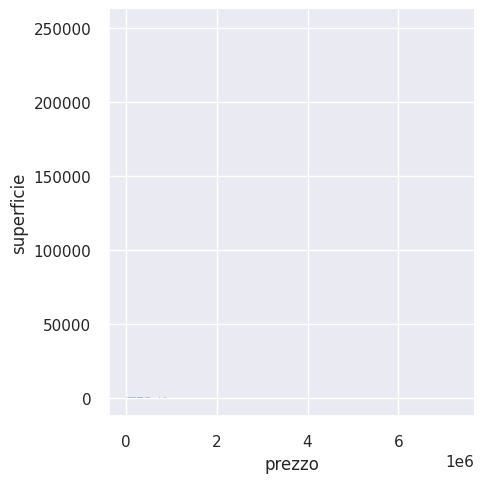

In [ ]:
sns.displot(data = df, x='prezzo', y='superficie')

hm... un'altra pulizia veloce

In [ ]:
df[df['prezzo'] >= 2000000]

,pagina,zona,titolo,data_aggiornamento,descrizione,prezzo_su_richiesta,contratto,tipologia,superficie,locali,piano,parzialmente arredato,cantina,giardino privato,prezzo,anno di costruzione,stato,efficienza energetica,classe_energetica,totale piani edificio,riscaldamento,armadio a muro,terrazza,certificazione energetica,climatizzatore,mansarda,cancello elettrico,caminetto,porta blindata,indice prest. energetica rinnovabile,prestazione energetica del fabbricato,fibra ottica,arredato,cucina,giardino comune,idromassaggio,taverna,videocitofono,impianto di allarme,prezzo_originale,sconto,uso edificio attuale,reception,aggiornato il,piscina,giardino privato e comune,portiere intera giornata,parcheggio bici,campo da tennis,luogo vendita,comune,superficie_commerciale,classe_immobile,parte_proprieta,tipo_cucina,altri_locali,camere_da_letto,bagni,ascensore,accesso_disabili,posti_auto_comune,posti_auto_privati,libero,spese_condominio_mensile,riscaldamento_tipo,riscaldamento_modo,riscaldamento_alimentazione,climatizzatore_tipo,climatizzatore_modo,eta_immobile,esposizione_esterna,infissi_esterni,balconi,impianto_tv,prezzo_per_m2
453,https://www.immobiliare.it/annunci/103051992/,centro,"Villa unifamiliare via Marconi, Centro, Porcia",2024-04-29,Elegante villa storica ristrutturata con parco...,False,Vendita,Villa unifamiliare,800.00,5+,Su più livelli,False,True,True,"2,250,000.00","2,006.00",Ottimo / Ristrutturato,126.00,E,3.00,"Autonomo, a pavimento, alimentato a metano",False,True,NaN,"Autonomo, freddo/caldo",True,False,True,False,NaN,NaN,False,False,True,False,True,False,True,True,NaN,NaN,NaN,False,NaN,True,NaN,False,False,False,NaN,porcia,NaN,signorile,Intera,abitabile,1.00,6.00,3+,True,False,0,1,True,0.00,a pavimento,Autonomo,alimentato a metano,freddo/caldo,Autonomo,18.00,NaN,NaN,1.00,singolo,"2,812.50"
610,https://www.immobiliare.it/annunci/66313393/,san-valentino-ospedale,"Rustico, buono stato, 250000 m², Rorai Grande,...",2018-03-12,Pordenone (8/10 Km).Vendesi Azienda agricola d...,False,Vendita,Rustico,"250,000.00",1,NaN,False,False,False,"2,000,000.00",NaN,Buono / Abitabile,NaN,G,NaN,NaN,False,False,NaN,NaN,False,False,False,False,NaN,NaN,False,False,False,False,False,False,False,False,NaN,NaN,NaN,False,NaN,False,NaN,False,False,False,NaN,pordenone,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,0,0,True,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.00
867,https://www.immobiliare.it/annunci/66313393/,rorai-grande-grigoletti,"Rustico, buono stato, 250000 m², Rorai Grande,...",2018-03-12,Pordenone (8/10 Km).Vendesi Azienda agricola d...,False,Vendita,Rustico,"250,000.00",1,NaN,False,False,False,"2,000,000.00",NaN,Buono / Abitabile,NaN,G,NaN,NaN,False,False,NaN,NaN,False,False,False,False,NaN,NaN,False,False,False,False,False,False,False,False,NaN,NaN,NaN,False,NaN,False,NaN,False,False,False,NaN,pordenone,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,0,0,True,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.00
1181,https://www.immobiliare.it/annunci/81518419/,centro-storico,Palazzo - Edificio in Vendita,2022-11-17,Terracielo a reddito Pordenone cittàVendesi te...,False,Vendita | Immobile a reddito,Palazzo - Edificio,"11,465.00",1,2 piani,False,False,False,"7,300,000.00",NaN,Buono / Abitabile,175.00,E,2.00,NaN,False,False,NaN,NaN,False,False,False,False,NaN,NaN,False,False,False,False,False,False,False,False,NaN,NaN,Residenziale,False,NaN,False,NaN,False,False,False,NaN,pordenone,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,0,0,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,636.72


In [ ]:
df_possibile = df[df['prezzo'] < 2000000]

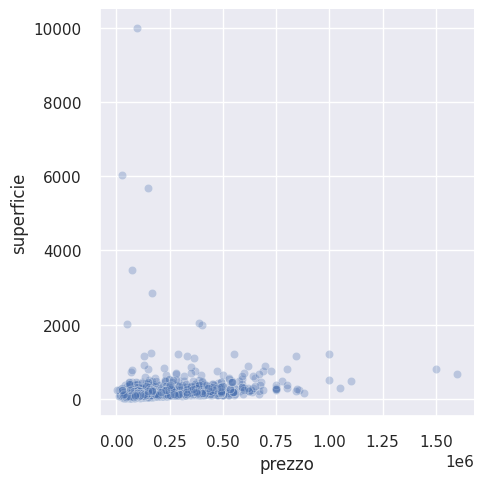

In [ ]:
sns.relplot(x="prezzo", y="superficie", data=df_possibile, alpha=0.3)

Distribuizione

(0.0, 2000.0)

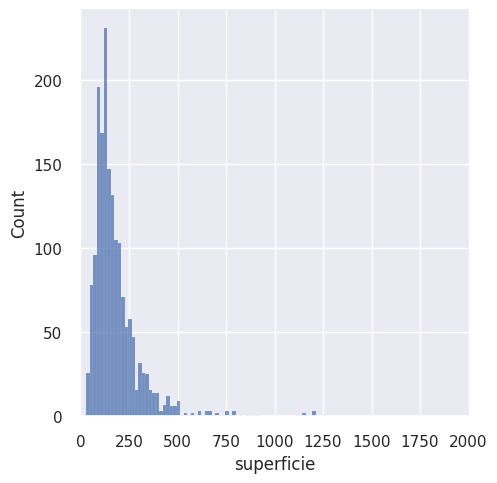

In [ ]:
sns.displot(df_possibile["superficie"])
plt.xlim([0, 2000])


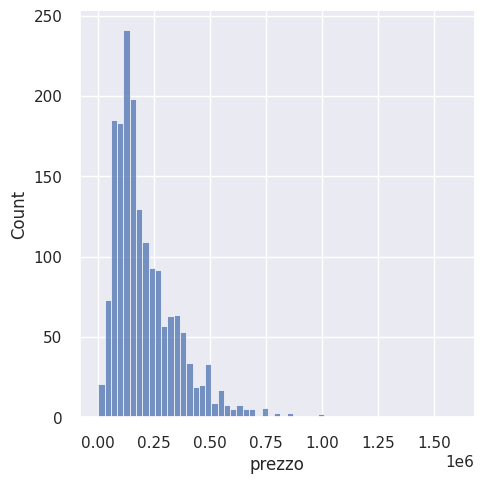

In [ ]:
sns.displot(df_possibile["prezzo"])

E entrambi?

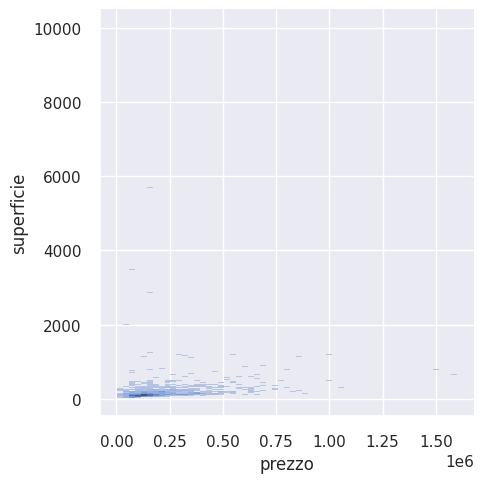

In [ ]:
sns.displot(df_possibile, x="prezzo", y="superficie")

(array([     0., 100000., 200000., 300000., 400000., 500000., 600000.,
        700000., 800000.]),
 [Text(0.0, 0, '0'),
  Text(100000.0, 0, '100000'),
  Text(200000.0, 0, '200000'),
  Text(300000.0, 0, '300000'),
  Text(400000.0, 0, '400000'),
  Text(500000.0, 0, '500000'),
  Text(600000.0, 0, '600000'),
  Text(700000.0, 0, '700000'),
  Text(800000.0, 0, '800000')])

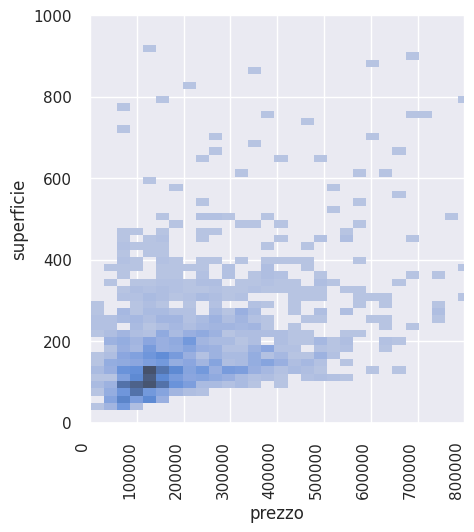

In [ ]:
sns.displot(df_possibile, x="prezzo", y="superficie")
plt.ylim([0, 1000])
plt.xlim([0, 800000])
plt.xticks(rotation=90, ha='right')

E il stato?

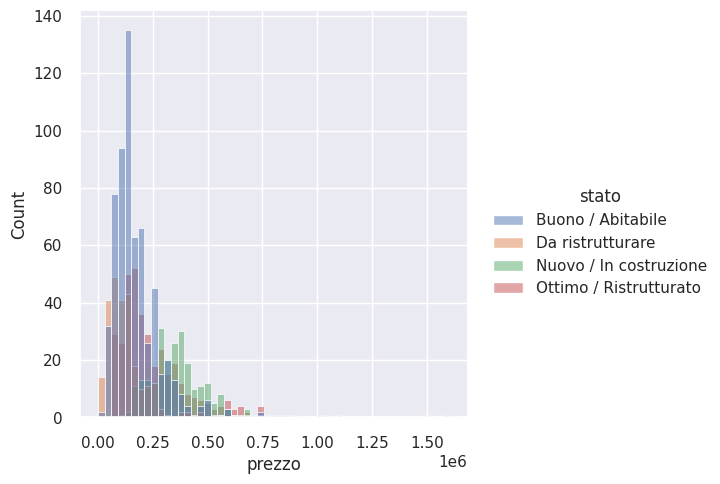

In [ ]:
sns.displot(data = df_possibile, x="prezzo", hue='stato')

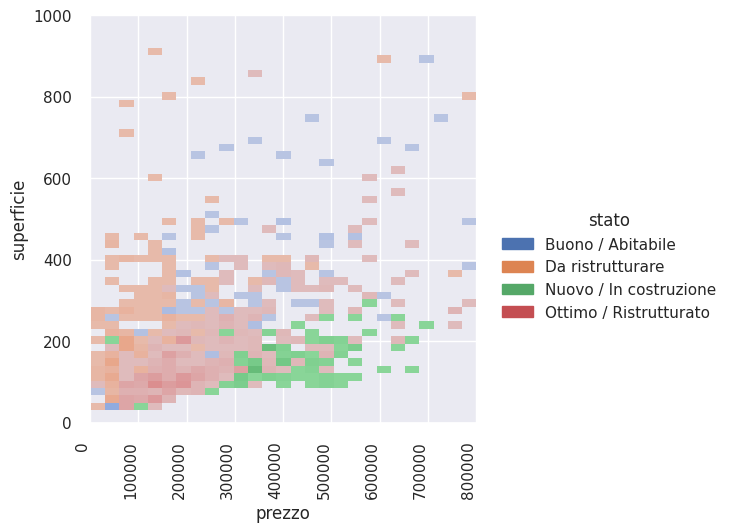

In [ ]:
sns.displot(df_possibile, x="prezzo", y="superficie", hue = 'stato')
plt.ylim([0, 1000])
plt.xlim([0, 800000])
plt.xticks(rotation=90, ha='right')
plt.show()

(0.0, 800000.0)

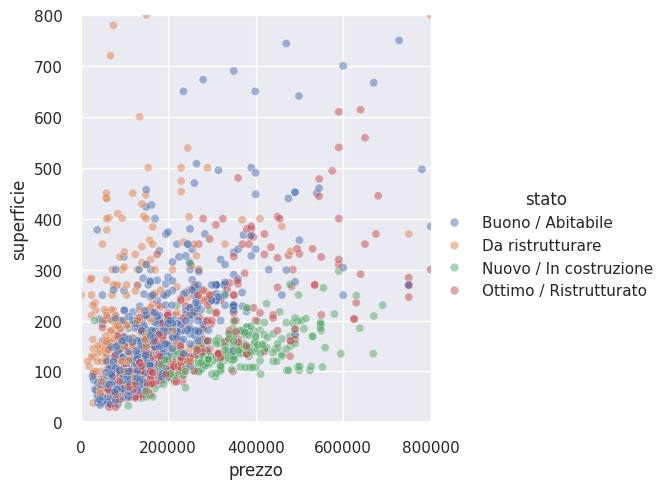

In [ ]:
sns.relplot(x="prezzo", y="superficie", hue='stato', data=df_possibile, alpha=0.5)
plt.ylim([0, 800])
plt.xlim([0, 800000])

Altre rilazione

(0.0, 800000.0)

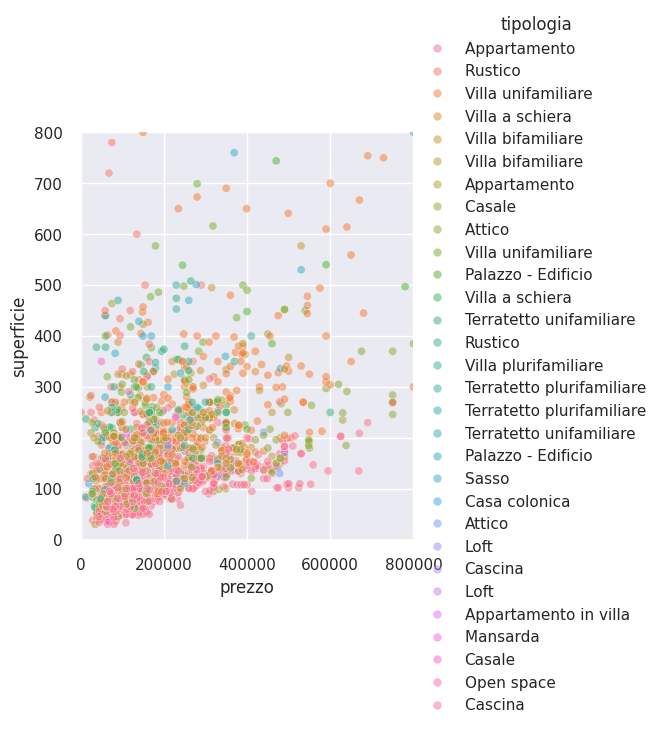

In [ ]:
sns.relplot(x="prezzo", y="superficie", hue='tipologia', data=df_possibile, alpha=0.5)
plt.ylim([0, 800])
plt.xlim([0, 800000])

(0.0, 500000.0)

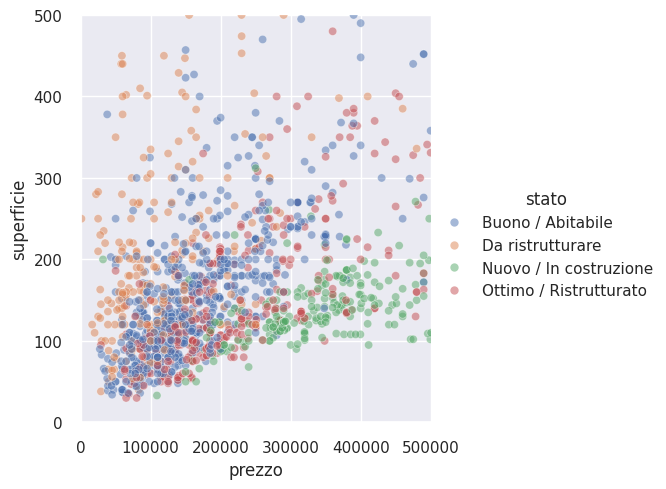

In [ ]:
sns.relplot(x="prezzo", y="superficie", hue='stato', data=df_possibile, alpha=0.5)
plt.ylim([0, 500])
plt.xlim([0, 500000])

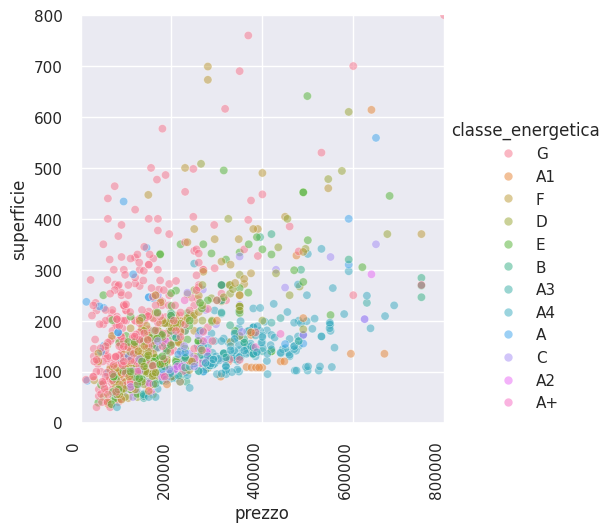

In [ ]:
sns.relplot(x="prezzo", y="superficie", hue='classe_energetica', data=df_possibile, alpha=0.5)
plt.ylim([0, 800])
plt.xlim([0, 800000])
plt.xticks(rotation=90, ha='right')
plt.show()

Analisi di categorie

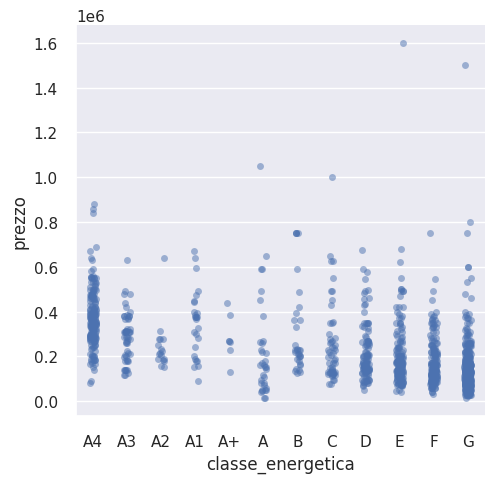

In [ ]:
sns.catplot(y="prezzo", x="classe_energetica",  data=df_possibile, order=['A4', 'A3', 'A2', 'A1', 'A+', 'A', 'B', 'C', 'D', 'E', 'F', 'G'], alpha=0.5)

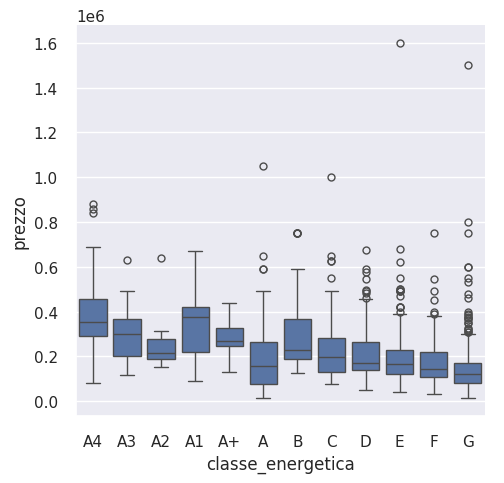

In [ ]:
sns.catplot(y="prezzo", x="classe_energetica",  data=df_possibile, order=['A4', 'A3', 'A2', 'A1', 'A+', 'A', 'B', 'C', 'D', 'E', 'F', 'G'], kind='box')

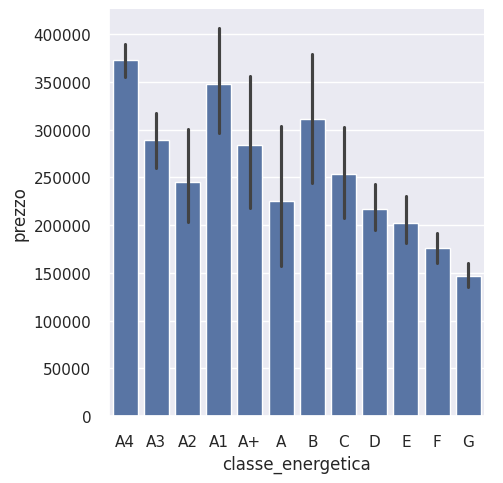

In [ ]:
sns.catplot(y="prezzo", x="classe_energetica",  data=df_possibile, order=['A4', 'A3', 'A2', 'A1', 'A+', 'A', 'B', 'C', 'D', 'E', 'F', 'G'], kind='bar')

Acune altre rilazione

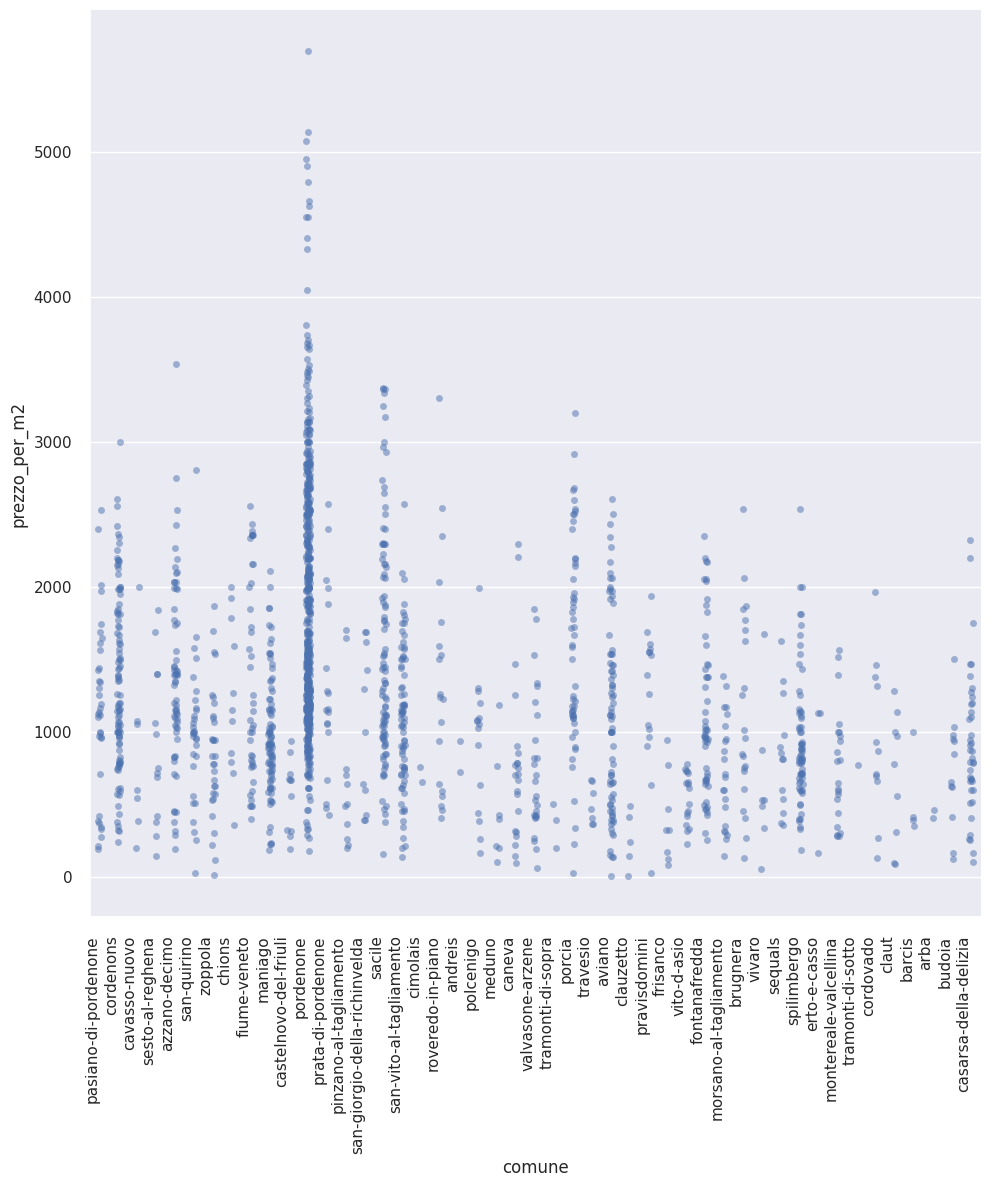

In [ ]:
sns.catplot(y="prezzo_per_m2", x="comune",  data=df_possibile, alpha=0.5, height=10)
plt.xticks(rotation=90, ha='right')
plt.show()

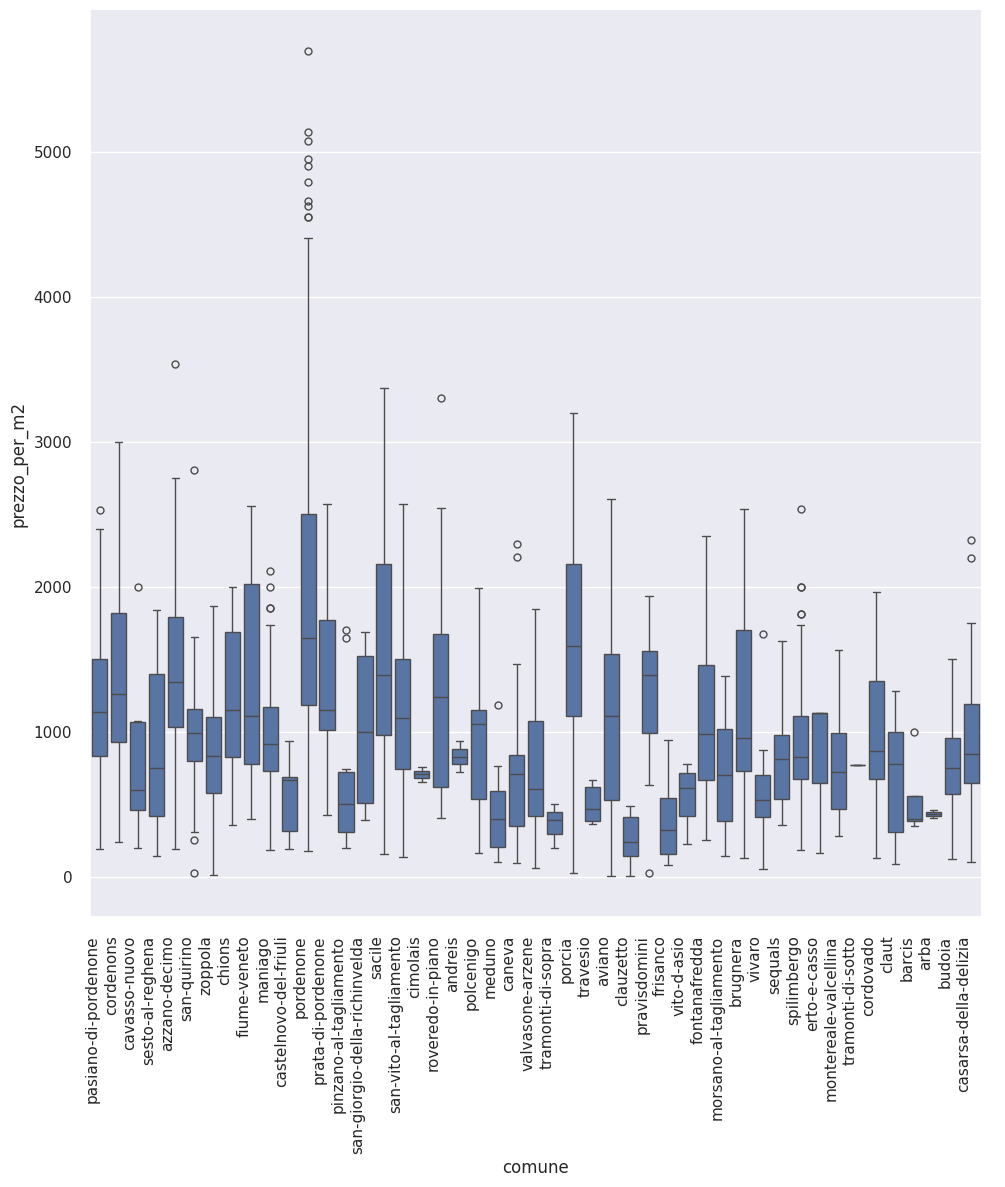

In [ ]:
sns.catplot(y="prezzo_per_m2", x="comune",  data=df_possibile, kind='box', height=10)
plt.xticks(rotation=90, ha='right')
plt.show()

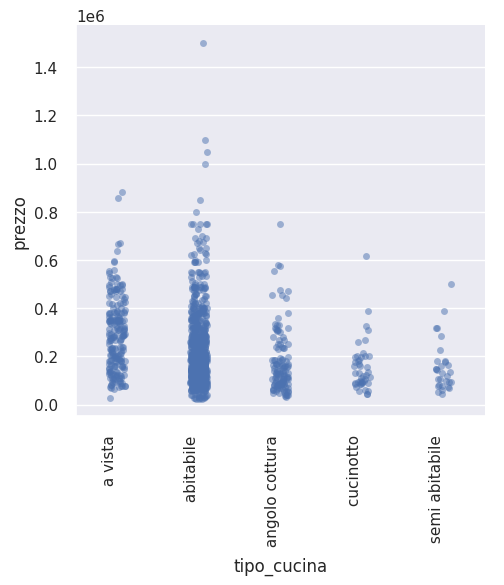

In [ ]:
sns.catplot(y="prezzo", x="tipo_cucina",  data=df_possibile, alpha=0.5)
plt.xticks(rotation=90, ha='right')
plt.show()

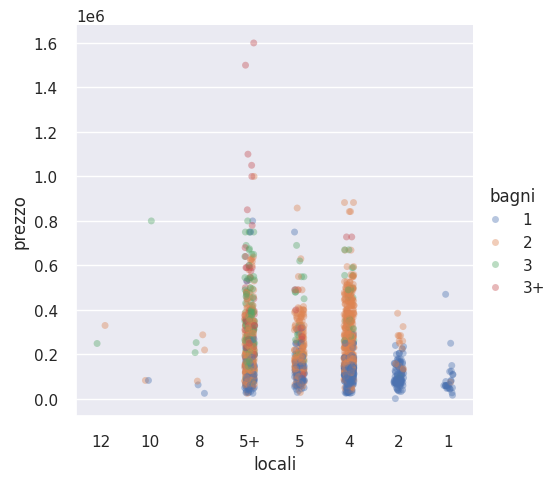

In [ ]:
sns.catplot(y="prezzo", x="locali", hue="bagni",  data=df_possibile, order=['12', '10', '8', '5+', '5', '4', '4', '2', '1'], alpha=0.4)

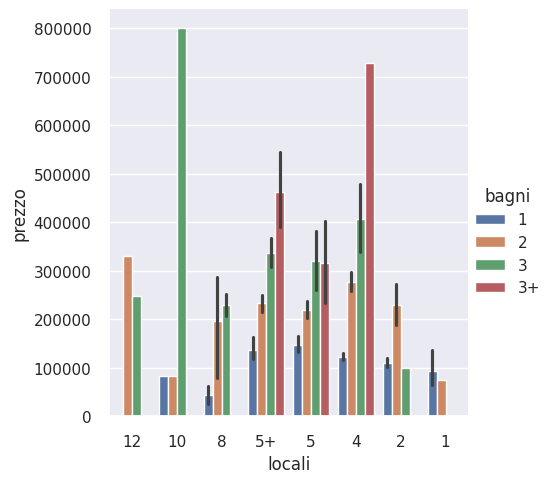

In [ ]:
sns.catplot(y="prezzo", x="locali", hue="bagni",  data=df_possibile, order=['12', '10', '8', '5+', '5', '4', '4', '2', '1'], kind='bar')

In [ ]:
df.columns

Index(['pagina', 'zona', 'titolo', 'data_aggiornamento', 'descrizione',
       'prezzo_su_richiesta', 'contratto', 'tipologia', 'superficie', 'locali',
       'piano', 'parzialmente arredato', 'cantina', 'giardino privato',
       'prezzo', 'anno di costruzione', 'stato', 'efficienza energetica',
       'classe_energetica', 'totale piani edificio', 'riscaldamento',
       'armadio a muro', 'terrazza', 'certificazione energetica',
       'climatizzatore', 'mansarda', 'cancello elettrico', 'caminetto',
       'porta blindata', 'indice prest. energetica rinnovabile',
       'prestazione energetica del fabbricato', 'fibra ottica', 'arredato',
       'cucina', 'giardino comune', 'idromassaggio', 'taverna',
       'videocitofono', 'impianto di allarme', 'prezzo_originale', 'sconto',
       'uso edificio attuale', 'reception', 'aggiornato il', 'piscina',
       'giardino privato e comune', 'portiere intera giornata',
       'parcheggio bici', 'campo da tennis', 'luogo vendita', 'comune',
    

Modellagio

In [ ]:
temp = df_possibile.copy()
temp["classe_energetica"] = temp["classe_energetica"].replace(['A4', 'A3', 'A2', 'A1', 'A+', 'A', 'B', 'C', 'D', 'E', 'F', 'G'], [0,1,2,3,4,5,6,7,8,9,10,11])

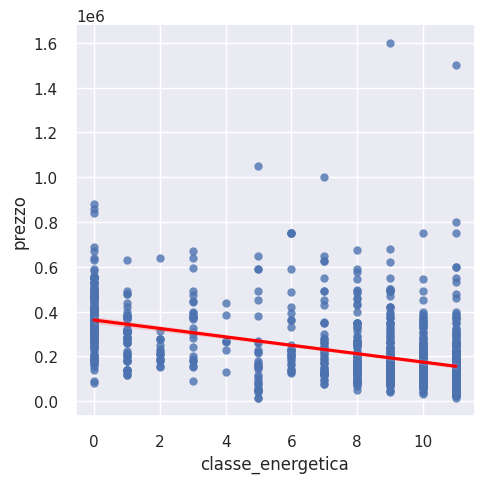

In [ ]:
sns.lmplot(y="prezzo", x="classe_energetica",  data=temp, line_kws={"color": "red"})

<Axes: xlabel='prezzo_per_m2', ylabel='superficie'>

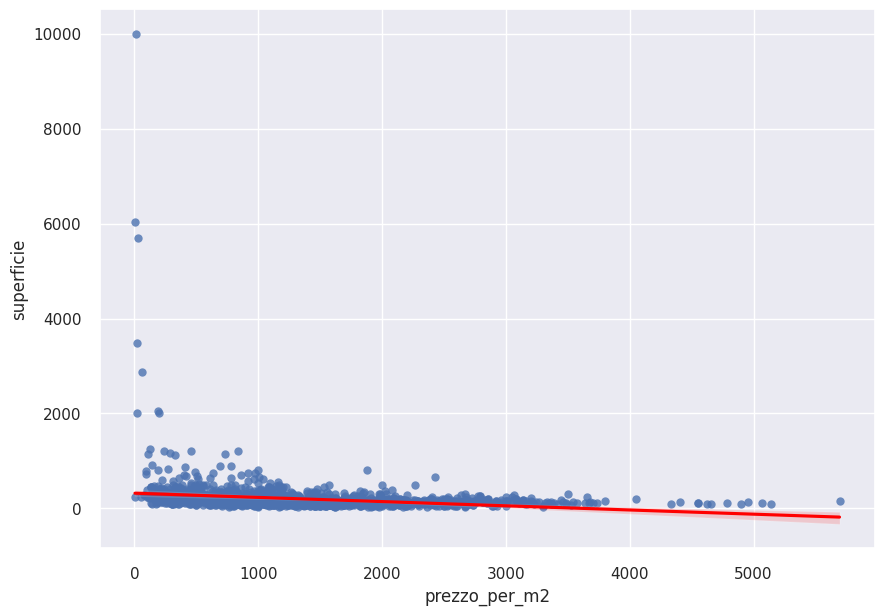

In [ ]:
f, ax = plt.subplots(1,1, figsize=(10, 7) )
sns.regplot(x="prezzo_per_m2", y="superficie", data=df_possibile, ax=ax, line_kws={"color": "red"})


<Axes: xlabel='prezzo_per_m2', ylabel='prezzo'>

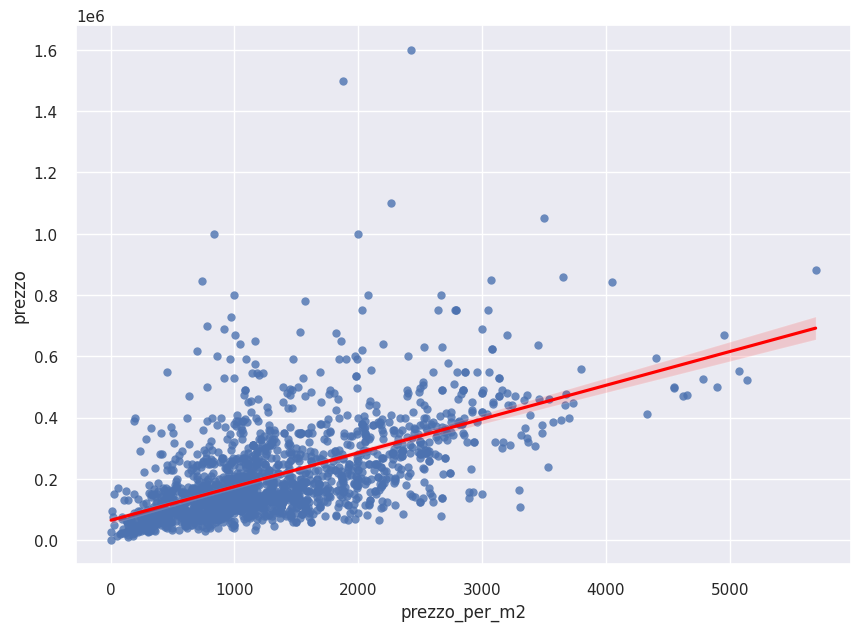

In [ ]:
f, ax = plt.subplots(1,1, figsize=(10, 7) )
sns.regplot(x="prezzo_per_m2", y="prezzo", data=df_possibile, ax=ax, line_kws={"color": "red"})

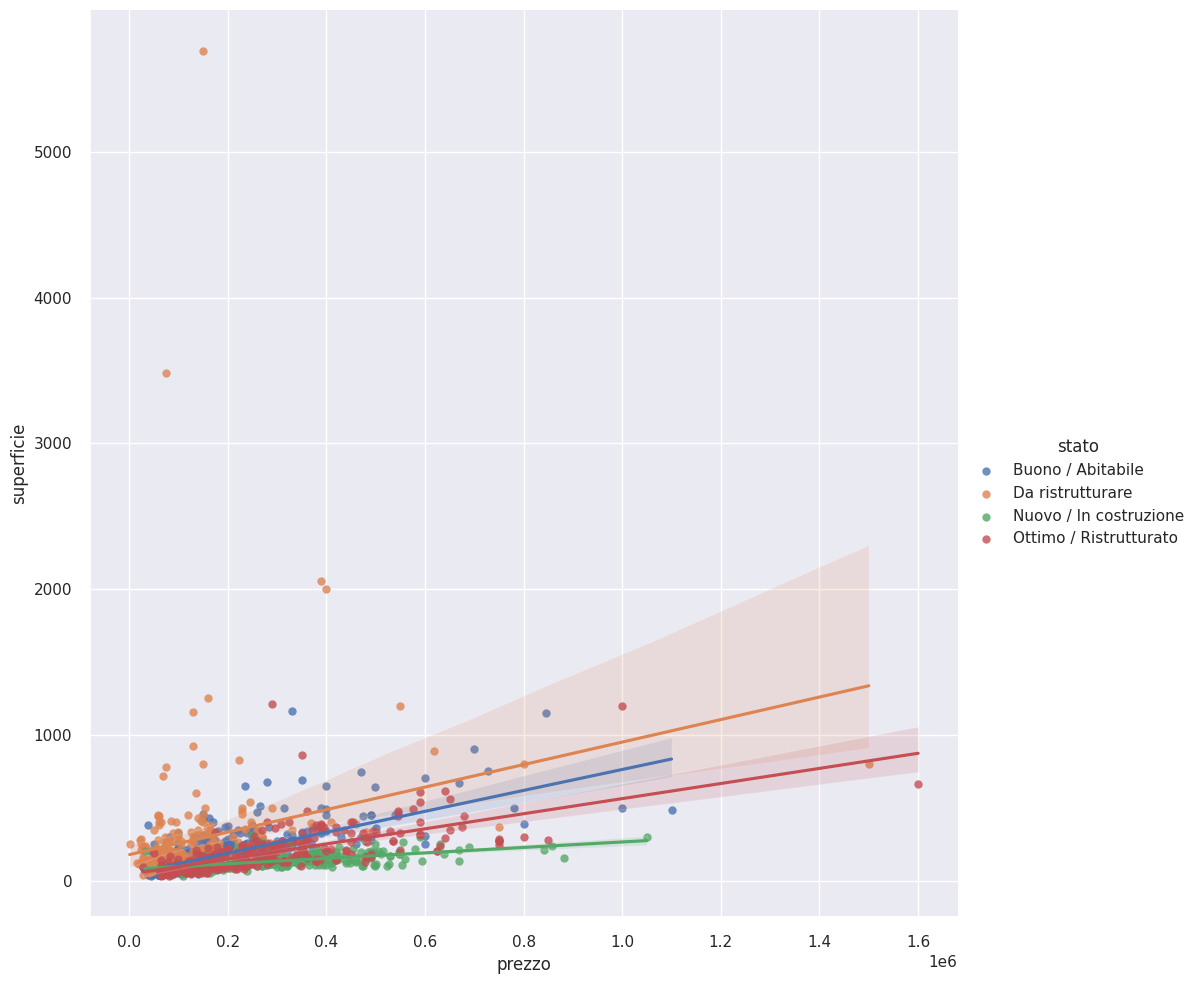

In [ ]:
sns.lmplot(x="prezzo", y="superficie", hue='stato', data=df_possibile, height=10)

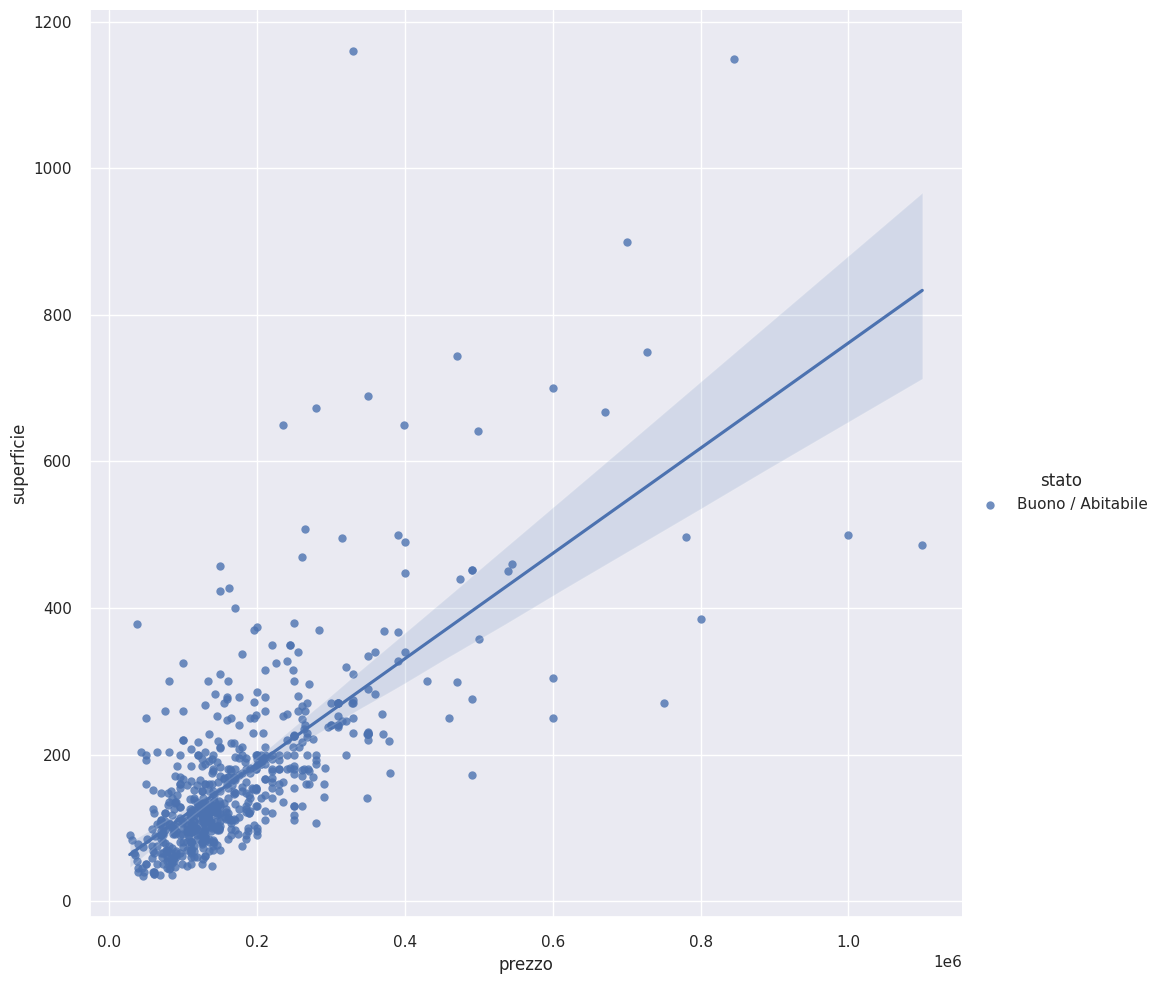

In [ ]:
sns.lmplot(x="prezzo", y="superficie", hue='stato', data=df_possibile[df_possibile["stato"]=="Buono / Abitabile"], height=10)

In [ ]:
df_possibile.columns

Index(['pagina', 'zona', 'titolo', 'data_aggiornamento', 'descrizione',
       'prezzo_su_richiesta', 'contratto', 'tipologia', 'superficie', 'locali',
       'piano', 'parzialmente arredato', 'cantina', 'giardino privato',
       'prezzo', 'anno di costruzione', 'stato', 'efficienza energetica',
       'classe_energetica', 'totale piani edificio', 'riscaldamento',
       'armadio a muro', 'terrazza', 'certificazione energetica',
       'climatizzatore', 'mansarda', 'cancello elettrico', 'caminetto',
       'porta blindata', 'indice prest. energetica rinnovabile',
       'prestazione energetica del fabbricato', 'fibra ottica', 'arredato',
       'cucina', 'giardino comune', 'idromassaggio', 'taverna',
       'videocitofono', 'impianto di allarme', 'prezzo_originale', 'sconto',
       'uso edificio attuale', 'reception', 'aggiornato il', 'piscina',
       'giardino privato e comune', 'portiere intera giornata',
       'parcheggio bici', 'campo da tennis', 'luogo vendita', 'comune',
    

In [ ]:
sns.lmplot(x="prezzo", y="superficie", hue='stato', data=df_possibile, height=10)

# Machine Learning

Regressione

In [ ]:
df_m = pd.read_csv(CARTELLA_DOCUMENTI+'immobile_puliti.csv').drop([
      'pagina', 'titolo', 'data_aggiornamento', 'descrizione', 'prezzo_per_m2','cucina', 'indice prest. energetica rinnovabile', 'aggiornato il',
      'parte_proprieta','luogo vendita'
    ], axis=1)

In [ ]:
df_m.head()

,zona,prezzo_su_richiesta,contratto,tipologia,superficie,locali,piano,totale piani edificio,terrazza,cantina,...,riscaldamento_tipo,riscaldamento_modo,riscaldamento_alimentazione,climatizzatore_tipo,climatizzatore_modo,eta_immobile,esposizione_esterna,infissi_esterni,balconi,impianto_tv
0,vacile,False,Vendita,Villa bifamiliare,322.00,5,Piano terra,2.00,True,True,...,a radiatori,Autonomo,alimentato a gasolio,NaN,NaN,57.00,NaN,NaN,NaN,NaN
1,bagnarola,False,Vendita | Immobile a reddito,Appartamento,80.00,3,1°,1.00,True,True,...,a radiatori,Autonomo,alimentato a metano,freddo/caldo,Autonomo,19.00,interna,in doppio vetro / legno,1.00,singolo
2,bagnarola,False,Vendita,Appartamento,107.00,3,2°,2.00,True,False,...,a stufa,Autonomo,NaN,freddo,Autonomo,55.00,NaN,in doppio vetro / legno,NaN,NaN
3,bagnarola,False,Vendita,Attico,160.00,5+,2 piani,1.00,True,True,...,a radiatori,Autonomo,alimentato a metano,NaN,Autonomo,24.00,doppia,in doppio vetro / legno,1.00,singolo
4,bagnarola,False,Vendita,Terratetto unifamiliare,250.00,4,Piano terra,NaN,False,False,...,NaN,NaN,NaN,NaN,NaN,38.00,NaN,NaN,NaN,NaN


In [ ]:
s = regression.setup(
      df_m[df_m['prezzo'].notnull()],
      target = 'prezzo',
      numeric_features = ['superficie_commerciale', 'ascensore', 'accesso_disabili', 'prezzo_su_richiesta', 'superficie', 'cancello elettrico', 'caminetto', 'impianto di allarme', 'terrazza', 'cantina',
         'giardino privato', 'anno di costruzione', 'efficienza energetica', 'idromassaggio', 'taverna', 'armadio a muro',
         'parzialmente arredato', 'videocitofono', 'arredato', 'giardino comune', 'fibra ottica',  'mansarda',  'campo da tennis', 'piscina',
         'porta blindata','prezzo_originale', 'sconto', 'giardino privato e comune','altri_locali', 'camere_da_letto',
         'parcheggio bici', 'portiere intera giornata', 'posti_auto_comune', 'posti_auto_privati', 'libero',  'spese_condominio_mensile', 'balconi', 'eta_immobile',
      ],
      categorical_features = ['zona', 'comune', 'contratto', 'tipologia',  'locali', 'piano', 'totale piani edificio', 'stato', 'riscaldamento', 'climatizzatore', 'classe_energetica', 'certificazione energetica',
         'prestazione energetica del fabbricato',  'uso edificio attuale', 'classe_immobile', 'tipo_cucina',
         'bagni', 'riscaldamento_tipo', 'riscaldamento_modo', 'riscaldamento_alimentazione', 'climatizzatore_tipo',
         'climatizzatore_modo', 'esposizione_esterna', 'infissi_esterni', 'impianto_tv'
      ],
      max_encoding_ohe=100
  )

,Description,Value
0,Session id,351
1,Target,prezzo
2,Target type,Regression
3,Original data shape,"(1751, 65)"
4,Transformed data shape,"(1751, 407)"
5,Transformed train set shape,"(1225, 407)"
6,Transformed test set shape,"(526, 407)"
7,Numeric features,38
8,Categorical features,25
9,Rows with missing values,100.0%


In [ ]:
bests = regression.compare_models(n_select=3)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,58056.7003,41516114530.5800,146522.8635,0.5960,0.3898,0.3520,7.8290
lightgbm,Light Gradient Boosting Machine,66203.6105,47770695798.5982,164283.9386,0.5152,0.4804,0.4425,1.2880
rf,Random Forest Regressor,63802.7647,52766342320.1643,167172.4127,0.4818,0.4301,0.4260,4.1100
gbr,Gradient Boosting Regressor,63611.7966,53172266008.0310,163438.2925,0.4743,0.4276,0.4186,1.6170
en,Elastic Net,81752.3101,57004905497.1695,180316.3839,0.3344,0.5592,0.6343,1.4000
omp,Orthogonal Matching Pursuit,93512.8171,58319831318.5874,188507.7122,0.2997,0.7302,0.5950,1.1020
dt,Decision Tree Regressor,84094.1885,62542733261.9112,192045.5306,0.2881,0.5909,0.5021,0.9230
knn,K Neighbors Regressor,87505.2219,61481723084.8000,191275.7023,0.2835,0.5867,0.6891,0.9210
llar,Lasso Least Angle Regression,97954.6917,60066373923.6859,194505.5905,0.2355,0.7594,0.6930,0.7320
ridge,Ridge Regression,104448.3316,59823748427.0954,197197.3775,0.1961,0.8314,0.7462,0.6750


Processing:   0%|          | 0/87 [00:00<?, ?it/s]

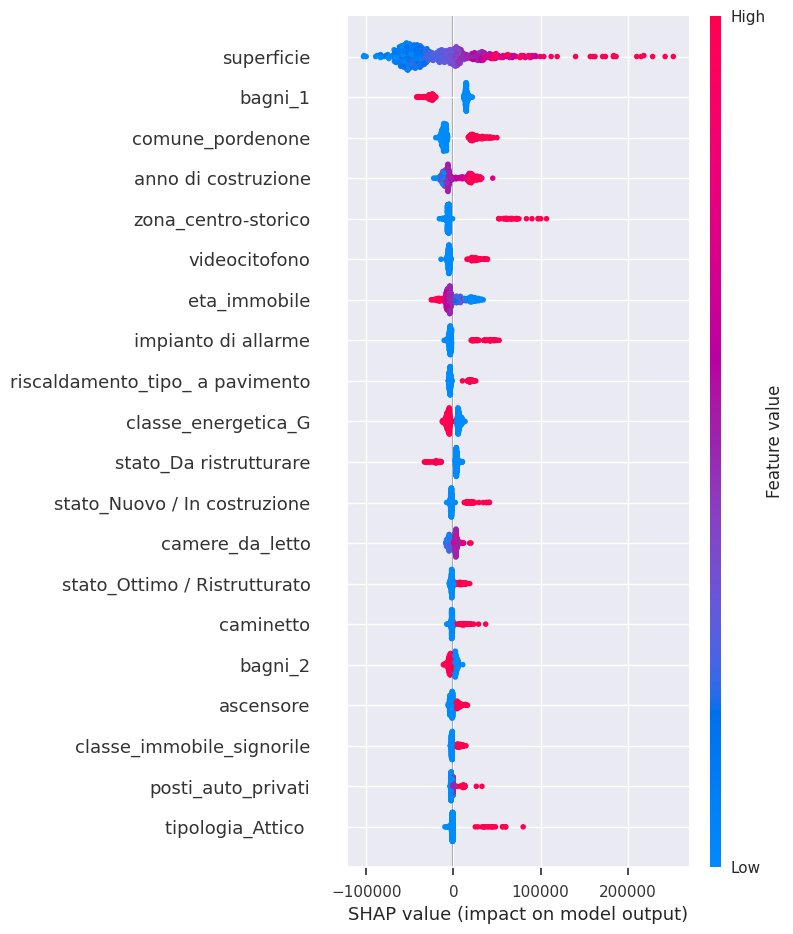

In [ ]:
regression.interpret_model(bests[0], plot = 'summary')

In [ ]:
data_to_predict = {
  'superficie': 100.0,
  'classe_energetica': 'A',
  'bagni': 2,
  'contratto': 'Vendita',
  'stato': 'Ottimo / Ristrutturato',
  'comune': 'pordenone', #bagnarola
  'zona': 'vallenoncello',
  'prezzo_su_richiesta': False,
  'tipologia': None,
  'locali': None,
  'piano': None,
  'totale piani edificio': None,
  'cancello elettrico': None,
  'caminetto': None,
  'impianto di allarme': None,
  'terrazza': None,
  'cantina': None,
  'giardino privato': None,
  'anno di costruzione':None,
  'riscaldamento': None,
  'climatizzatore': None,
  'efficienza energetica': None,
  'taverna': None,
  'prestazione energetica del fabbricato': None,
  'videocitofono': None,
  'arredato': None,
  'giardino comune': None,
  'idromassaggio': None,
  'armadio a muro': None,
  'parzialmente arredato': None,
  'certificazione energetica': None,
  'fibra ottica': None,
  'mansarda': None,
  'porta blindata': None,
  'campo da tennis': None,
  'piscina': None,
  'uso edificio attuale': None,
  'prezzo_originale': None,
  'sconto': None,
  'giardino privato e comune': None,
  'parcheggio bici': None,
  'portiere intera giornata': None,
  'superficie_commerciale': None,
  'classe_immobile': None,
  'tipo_cucina': None,
  'altri_locali': None,
  'camere_da_letto': None,
  'ascensore': None,
  'accesso_disabili': None,
  'posti_auto_comune': None,
  'posti_auto_privati': None,
  'libero': None,
  'spese_condominio_mensile': None,
  'riscaldamento_tipo': None,
  'riscaldamento_modo': None,
  'riscaldamento_alimentazione': None,
  'climatizzatore_tipo': None,
  'climatizzatore_modo': None,
  'eta_immobile': None,
  'esposizione_esterna': None,
  'infissi_esterni': None,
  'balconi': None,
  'impianto_tv': None,
  'reception': False
}

In [ ]:
p = regression.predict_model(bests[0], pd.DataFrame([data_to_predict]))
p['prediction_label']

0             119,961.70
Name: prediction_label, dtype: float64

Classificazione

In [ ]:
df_m['mi_piace'] = (df_m['prezzo'] < 200000) & (df_m['superficie'] > 50) & (df_m['superficie'] < 200) & ( df_m['classe_energetica'].isin(['A4', 'A3', 'A2', 'A1', 'A+', 'A']) )

In [ ]:
df_m['mi_piace'].sum()

47

In [ ]:
s2 = classification.setup(
      df_m,
      target = 'mi_piace',
      numeric_features = ['prezzo', 'superficie_commerciale', 'ascensore', 'accesso_disabili', 'prezzo_su_richiesta', 'superficie', 'cancello elettrico', 'caminetto', 'impianto di allarme', 'terrazza', 'cantina',
         'giardino privato', 'anno di costruzione', 'efficienza energetica', 'idromassaggio', 'taverna', 'armadio a muro',
         'parzialmente arredato', 'videocitofono', 'arredato', 'giardino comune', 'fibra ottica',  'mansarda',  'campo da tennis', 'piscina',
         'porta blindata','prezzo_originale', 'sconto', 'giardino privato e comune','altri_locali', 'camere_da_letto',
         'parcheggio bici', 'portiere intera giornata', 'posti_auto_comune', 'posti_auto_privati', 'libero',  'spese_condominio_mensile', 'balconi', 'eta_immobile',
      ],
      categorical_features = ['zona', 'comune', 'contratto', 'tipologia',  'locali', 'piano', 'totale piani edificio', 'stato', 'riscaldamento', 'climatizzatore', 'classe_energetica', 'certificazione energetica',
         'prestazione energetica del fabbricato',  'uso edificio attuale', 'classe_immobile', 'tipo_cucina',
         'bagni', 'riscaldamento_tipo', 'riscaldamento_modo', 'riscaldamento_alimentazione', 'climatizzatore_tipo',
         'climatizzatore_modo', 'esposizione_esterna', 'infissi_esterni', 'impianto_tv'
      ],
      max_encoding_ohe=100,
      #fix_imbalance=True
  )

,Description,Value
0,Session id,8125
1,Target,mi_piace
2,Target type,Binary
3,Original data shape,"(1895, 66)"
4,Transformed data shape,"(1895, 181)"
5,Transformed train set shape,"(1326, 181)"
6,Transformed test set shape,"(569, 181)"
7,Numeric features,39
8,Categorical features,25
9,Rows with missing values,100.0%


In [ ]:
bests2 = classification.compare_models(n_select=3)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ada,Ada Boost Classifier,0.9932,0.9857,0.7833,0.9500,0.8364,0.8332,0.8481,0.9250
dt,Decision Tree Classifier,0.9925,0.9110,0.8250,0.8883,0.8441,0.8403,0.8468,0.8930
catboost,CatBoost Classifier,0.9895,0.9955,0.6417,0.9167,0.7457,0.7406,0.7576,7.4780
gbc,Gradient Boosting Classifier,0.9887,0.9971,0.6667,0.8800,0.7294,0.7241,0.7457,1.4300
lightgbm,Light Gradient Boosting Machine,0.9864,0.9924,0.4750,0.9500,0.6190,0.6132,0.6582,1.2160
xgboost,Extreme Gradient Boosting,0.9849,0.9759,0.4167,0.8500,0.5424,0.5370,0.5802,0.7240
et,Extra Trees Classifier,0.9811,0.9889,0.3083,0.7333,0.4200,0.4144,0.4619,1.1050
rf,Random Forest Classifier,0.9796,0.9894,0.1833,0.6000,0.2800,0.2762,0.3280,0.8880
ridge,Ridge Classifier,0.9759,0.9790,0.0667,0.2000,0.1000,0.0977,0.1133,0.7560
lr,Logistic Regression,0.9751,0.8292,0.1333,0.2167,0.1567,0.1524,0.1610,0.9930


Processing:   0%|          | 0/71 [00:00<?, ?it/s]

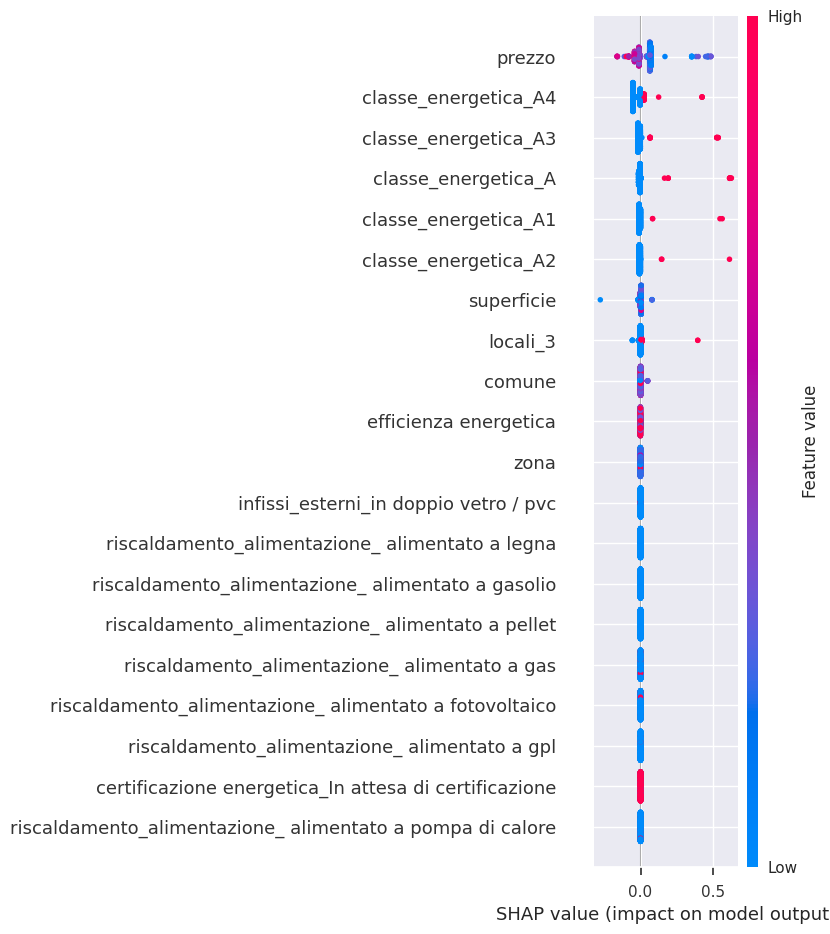

In [ ]:
classification.interpret_model(bests2[0], plot = 'summary')

In [ ]:
p = classification.predict_model(bests2[0], df_m[df_m['mi_piace']==True])
p

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Ada Boost Classifier,0.9574,0,0.9574,1.0000,0.9783,0.0000,0.0000


,zona,prezzo_su_richiesta,contratto,tipologia,superficie,locali,piano,totale piani edificio,terrazza,cantina,...,climatizzatore_tipo,climatizzatore_modo,eta_immobile,esposizione_esterna,infissi_esterni,balconi,impianto_tv,mi_piace,prediction_label,prediction_score
24,centro,False,Vendita,Terratetto unifamiliare,151.00,5+,NaN,NaN,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,1,0.79
29,centro,False,Vendita,Villa a schiera,155.00,5+,2 piani,NaN,True,False,...,NaN,NaN,44.00,NaN,NaN,NaN,NaN,True,1,0.78
42,centro,False,Vendita,Appartamento,100.00,3,2°,3.00,True,True,...,NaN,NaN,1.00,NaN,NaN,NaN,NaN,True,1,0.65
43,centro,False,Vendita,Appartamento,120.00,4,1°,NaN,True,False,...,NaN,NaN,1.00,NaN,NaN,NaN,NaN,True,1,0.79
44,centro,False,Vendita,Appartamento,120.00,4,Piano terra,3.00,True,True,...,freddo,Autonomo,NaN,NaN,NaN,NaN,NaN,True,1,0.65
128,morsano,False,Vendita,Attico,142.00,5+,2°,3.00,True,False,...,freddo,Autonomo,18.00,NaN,NaN,1.00,NaN,True,1,0.78
164,centro,False,Vendita,Appartamento,100.00,4,1°,2.00,True,False,...,NaN,Autonomo,NaN,doppia,NaN,NaN,NaN,True,1,0.80
165,centro,False,Vendita,Appartamento,100.00,5+,1°,2.00,True,False,...,NaN,Autonomo,NaN,NaN,NaN,NaN,NaN,True,1,0.80
166,centro,False,Vendita,Appartamento,90.00,4,2°,2.00,True,False,...,NaN,Autonomo,NaN,doppia,NaN,NaN,NaN,True,1,0.80
198,centro,False,Vendita,Villa unifamiliare,95.00,2,Piano terra,2.00,False,False,...,freddo/caldo,Autonomo,2.00,NaN,NaN,NaN,NaN,True,1,0.79


In [ ]:
p = classification.predict_model(bests2[0], df_m[df_m['mi_piace']==False])
p

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Ada Boost Classifier,1.0000,0,0.0000,0.0000,0.0000,nan,0.0000


,zona,prezzo_su_richiesta,contratto,tipologia,superficie,locali,piano,totale piani edificio,terrazza,cantina,...,climatizzatore_tipo,climatizzatore_modo,eta_immobile,esposizione_esterna,infissi_esterni,balconi,impianto_tv,mi_piace,prediction_label,prediction_score
0,vacile,False,Vendita,Villa bifamiliare,322.00,5,Piano terra,2.00,True,True,...,NaN,NaN,57.00,NaN,NaN,NaN,NaN,False,0,0.99
1,bagnarola,False,Vendita | Immobile a reddito,Appartamento,80.00,3,1°,1.00,True,True,...,freddo/caldo,Autonomo,19.00,interna,in doppio vetro / legno,1.00,singolo,False,0,0.81
2,bagnarola,False,Vendita,Appartamento,107.00,3,2°,2.00,True,False,...,freddo,Autonomo,55.00,NaN,in doppio vetro / legno,NaN,NaN,False,0,0.89
3,bagnarola,False,Vendita,Attico,160.00,5+,2 piani,1.00,True,True,...,NaN,Autonomo,24.00,doppia,in doppio vetro / legno,1.00,singolo,False,0,0.90
4,bagnarola,False,Vendita,Terratetto unifamiliare,250.00,4,Piano terra,NaN,False,False,...,NaN,NaN,38.00,NaN,NaN,NaN,NaN,False,0,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1890,centro,False,Vendita,Villa a schiera,146.00,4,Piano terra,NaN,True,True,...,freddo,Autonomo,42.00,NaN,in doppio vetro / legno,NaN,NaN,False,0,0.95
1891,centro,False,Vendita,Palazzo - Edificio,136.00,4,1°,1.00,False,False,...,freddo/caldo,Autonomo,2.00,NaN,in doppio vetro / legno,NaN,NaN,False,0,0.99
1892,centro,True,Vendita,Villa unifamiliare,409.00,5,Piano terra,2.00,True,True,...,NaN,NaN,56.00,NaN,NaN,NaN,NaN,False,0,1.00
1893,centro,False,Vendita,Appartamento,82.00,5+,2°,2.00,True,True,...,freddo/caldo,NaN,34.00,"sud, est, ovest",in doppio vetro / legno,NaN,NaN,False,0,0.90
